# Recherche de différents sentiers de croissance des économies en fonction de leurs composantes polluantes

## Introduction :

"Je suis pour une société écologique mais pas Amish" était les mots d'Emmmanuel Macron dés 2016 pour décrire son programme de campagne et son idéal politique de société. Cela fait écho à de nombreux débats entre partisan de la décroissance économique et partisan de la possibilité d'une croissance infinie sur des sentiers moins carbonés et indépendants de la consommation d'énergies non renouvelables. 

A un niveau plus académique, Jean Marc Jancovici, enseignant à Mines Paris Tech et membre du comité scientifique de la fondation Nicolas Hulot défend l'impossibilité d'une croissance infinie dans un monde finie dans le sillage de Dennis et Robert Meadows dans leur rapport de *Les limites de la croissance* de 1972 pour le club de Rome. Celui-ci, au travers de diverses simulations, mettait déjà en avant les difficultés que posait une croissance basée sur des énergies non-renouvelables et infinie dans un monde qui pour sa part est fini. Il est donc souvent difficile de trancher entre ces deux conclusions radicalement différentes, et nous nous proposons donc avec ce projet d'apporter notre modeste pierre à l'édifice  pour distinguer les différents chemins de croissance possibles pour les économies développées comme pour les économies en développement. Nous allons pour cela exploiter les données de la banque mondiale, disponibles gratuitement et librement sur https://data.worldbank.org/indicator. Cela nous fournit une source de donnée fiable et bien renseignée.

Notre objectif est d'étudier la période s'étalant de 1980 aux années 2010, afin de distinguer et caractériser les différentes trajectoires des économies, notamment du point de vue de l'utilisation et de la dépendance énergétique. Nous chercherons en particulier à voir s'il est possible de distinguer des pays plus responsables du point de vue écologique qui arrivent à avoir un bon développement économique. Dans ce cas, on pourrait chercher à caractériser grossièrement la structure de leur économie, notamment en cherchant les secteurs d'activité dynamiques. 

Après avoir fusionné nos données et construit des indicateurs pertinents pour comparer les économies, nous utiliseront des méthodes de clustering afin de regrouper les pays ayant des sentiers de développement proches. Nous aurons alors une idée des différentes trajectoires des économies et des consommations d'énergie durant cette période, et nous pourront voir si des sentiers de croissance verte se dégagent.


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from sklearn import preprocessing,decomposition,cluster
import sklearn as sklearn
import plotly.graph_objects as go
import re
import statsmodels.api as sm
import geoplot as gplt
import geopandas as gpd
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# On va télécharger les bases de données et repérer les variables pertinentes dans chacune des bases

### On commmence par créer les dataframe

Il faut légèrement modifier le fichier csv dézippé pour enlever les deux premières lignes, qui ne comprennent que des infos générales sur le format du fichier mais qui entrainaient un problème d'ouverture via la commande pd.read_csv car elles comportaient des virgules.

On peut ensuite ouvrir sereinement toutes les base modifiées ainsi.

In [140]:
agri_forest = pd.read_csv("chiffre_agri_foret_peche.csv")
augment_pib = pd.read_csv("chiffre_augment_pib.csv")
energie_utilisee = pd.read_csv("chiffre_energie_utilise.csv")
emission_GES = pd.read_csv("chiffre_GES_total.csv")
nucle_total = pd.read_csv('chiffre_nucle_total_nuke_total_fossile.csv')
part_indus_construc = pd.read_csv('chiffre_part_indus_construc.csv')
pib = pd.read_csv("chiffre_pib.csv")
pop = pd.read_csv('chiffre_population.csv')
nom_pays = pib['Country Name']


In [141]:
df_list  = [agri_forest, augment_pib, energie_utilisee, emission_GES, nucle_total, part_indus_construc, pib,pop]

### On fusionne les dataframe pour aggréger tous ces indicateurs

On peut envisager plusieurs manières de fusionner ces df. Soit on a en index Pays_Année et les colomnes correspondent chacune à un indice, soit on a Pays_Indicateur et les colonnes correspondent chacune a une année. Ce sont les formats wide et long.

Pour des raisons de lisibilité, on va conserver le nom de l'indicateur, et non pas son nom de code. On décide également d'utilser le format long.

On concatène les dataframes en utilisant un index commun, créé ci dessous sous le nom Pays_indic. On trie ensuite le dataframe obtenu pour des raisons de lisibilité, afin de regrouper tous les indicateurs d'un même pays.

In [142]:
for df in df_list :
    df['Pays_indic'] = df['Country Code'].str[:3] + '_' + df['Indicator Name'].str[:99]

df1 = pd.concat(df_list)
df1 = df1.sort_values('Pays_indic').set_index('Pays_indic')
df1.head(9)

Country Name Country Code  \
Pays_indic                                                                     
ABW_Agriculture, forestry, and fishing, value a...        Aruba          ABW   
ABW_Alternative and nuclear energy (% of total ...        Aruba          ABW   
ABW_Energy use (kg of oil equivalent per capita)          Aruba          ABW   
ABW_GDP (current US$)                                     Aruba          ABW   
ABW_GDP growth (annual %)                                 Aruba          ABW   
ABW_Industry (including construction), value ad...        Aruba          ABW   
ABW_Population, total                                     Aruba          ABW   
ABW_Émissions totales de GES (kt d’équivalent CO2)        Aruba          ABW   
AFG_Agriculture, forestry, and fishing, value a...  Afghanistan          AFG   

                                                                                       Indicator Name  \
Pays_indic                                                                                              
ABW_Agriculture, forestry, and fishing, value a...  Agriculture, forestry, and fishing, value adde...   
ABW_Alternative and nuclear energy (% of total ...  Alternative and nuclear energy (% of total ene...   
ABW_Energy use (kg of oil equivalent per capita)         Energy use (kg of oil equivalent per capita)   
ABW_GDP (current US$)                                                               GDP (current US$)   
ABW_GDP growth (annual %)                                                       GDP growth (annual %)   
ABW_Industry (including construction), value ad...  Industry (including construction), value added...   
ABW_Population, total                                                               Population, total   
ABW_Émissions totales de GES (kt d’équivalent CO2)     Émissions totales de GES (kt d’équivalent CO2)   
AFG_Agriculture, forestry, and fishing, value a...  Agriculture, forestry, and fishing, value adde...   

                                                       Indicator Code  \
Pays_indic                                                              
ABW_Agriculture, forestry, and fishing, value a...     NV.AGR.TOTL.ZS   
ABW_Alternative and nuclear energy (% of total ...  EG.USE.COMM.CL.ZS   
ABW_Energy use (kg of oil equivalent per capita)    EG.USE.PCAP.KG.OE   
ABW_GDP (current US$)                                  NY.GDP.MKTP.CD   
ABW_GDP growth (annual %)                           NY.GDP.MKTP.KD.ZG   
ABW_Industry (including construction), value ad...     NV.IND.TOTL.ZS   
ABW_Population, total                                     SP.POP.TOTL   
ABW_Émissions totales de GES (kt d’équivalent CO2)  EN.ATM.GHGT.KT.CE   
AFG_Agriculture, forestry, and fishing, value a...     NV.AGR.TOTL.ZS   

                                                       1960     1961     1962  \
Pays_indic                                                                      
ABW_Agriculture, forestry, and fishing, value a...      NaN      NaN      NaN   
ABW_Alternative and nuclear energy (% of total ...      NaN      NaN      NaN   
ABW_Energy use (kg of oil equivalent per capita)        NaN      NaN      NaN   
ABW_GDP (current US$)                                   NaN      NaN      NaN   
ABW_GDP growth (annual %)                               NaN      NaN      NaN   
ABW_Industry (including construction), value ad...      NaN      NaN      NaN   
ABW_Population, total                               54211.0  55438.0  56225.0   
ABW_Émissions totales de GES (kt d’équivalent CO2)      NaN      NaN      NaN   
AFG_Agriculture, forestry, and fishing, value a...      NaN      NaN      NaN   

                                                       1963     1964     1965  \
Pays_indic                                                                      
ABW_Agriculture, forestry, and fishing, value a...      NaN      NaN      NaN   
ABW_Alternative and nuclear energy (% of total ...      NaN      NaN      N

Afin de mieux manipuler le dataframe, on crée les fonctions suivantes qui nous permettent de jongler entre les noms des pays et leurs codes. 
On génère également un dictionnaire qui contient les noms de toutes les variables (dont certaines que l'on crée dans la cellule suivante), afin de faciliter la manipulation du dataframe.

In [143]:
#Fonction pour trouver les codes correspondants à un pays entre les codes de pays et le nom des pays :"
def refresh_dico(Name,Code,df):
    dico = {}
    for i in df[[Name,Code]].dropna().drop_duplicates().iterrows() :
        dico[i[1][Name]] = i[1][Code]
    return (dico)

def rech_ligne_pays (y,df) :
    expression = re.compile(dic_pays[y]+".*?;")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def rech_ligne_indic (y,df):
    expression = re.compile(".{,4}"+y+";")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

In [144]:
dic = {}
dic['pib'] = '_GDP (current US$)'
dic['pib_hab'] = '_GDP (current US$) par Tete'
dic['pib_growth'] = '_GDP growth (annual %)'
dic['pib_hab_growth'] = '_Croissance_GDP (current US$) par Tete (pourcent)'
dic['pop'] = '_Population, total'
dic['ges'] = '_Émissions totales de GES (kt d’équivalent CO2)'
dic['ges_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) (pourcent)	'
dic['ges_hab'] = '_Émissions totales de GES (kt d’équivalent CO2) par Tete'
dic['ges_hab_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)'
dic['industry'] = '_Industry (including construction), value added (% of GDP)'
dic['agr'] = '_Agriculture, forestry, and fishing, value added (% of GDP)'
dic['clean_nrj'] = '_Alternative and nuclear energy (% of total energy use)'
dic['nrj_hab'] = '_Energy use (kg of oil equivalent per capita)'
dic['nrj_hab_growth'] = '_Croissance_Energy use (kg of oil equivalent per capita) (pourcent)'

Maintenant que l'on a créé le dataframe aggrégé, on y ajoute des grandeurs qui pourraient potentiellement nous intéresser. Pour cela, on utilise notamment la fonction gen_par_tete afin de créer les grandeurs par tête, qui nous permettront de mieux comparer les pays entre eux en ayant des ordres de grandeur comparables. On décide également de générer sur le même modèle les variables nous indiquant l'évolution des variables liées à la consommation d'énergie chaque année, comme il s'agit des variables les plus importantes pour notre analyse.

In [145]:
dic_code = refresh_dico('Country Code','Country Name',df1)

def gen_croissance(variable):
    for i in dic_code.keys():
        df1.loc[i+'_Croissance'+variable+' (pourcent)']=100*df1.loc[i+variable][4:].astype(np.float64).diff() / (df1.loc[i+variable][4:].astype(np.float64)-df1.loc[i+variable][4:].astype(np.float64).diff())
        df1.loc[i+'_Croissance'+variable+' (pourcent)',['Country Name','Country Code']]=df1.loc[i+variable,['Country Name','Country Code']]
        df1.loc[i+'_Croissance'+variable+' (pourcent)','Indicator Name']='Croissance '+variable
    return 

def gen_par_tete(variable):
    for i in dic_code.keys():
        df1.loc[i+variable+' par Tete']= df1.loc[i+variable][4:].astype(np.float64) / df1.loc[i+'_Population, total'][4:].astype(np.float64)
        df1.loc[i+variable+' par Tete',['Country Name','Country Code']]=df1.loc[i+variable,['Country Name','Country Code']]
        df1.loc[i+variable+' par Tete','Indicator Name']= variable + ' par Tete'
    return

gen_par_tete('_GDP (current US$)')
gen_par_tete('_Émissions totales de GES (kt d’équivalent CO2)')
gen_croissance('_Émissions totales de GES (kt d’équivalent CO2)')
gen_croissance('_GDP (current US$) par Tete')
gen_croissance('_Émissions totales de GES (kt d’équivalent CO2) par Tete')
gen_croissance('_Energy use (kg of oil equivalent per capita)')

Maintenant que l'on a créé toutes les variables qui nous intéressaient pour chaque pays, on va s'attacher à nettoyer notre base.

### Suppression des colonnes

Pour rendre notre analyse plus robuste, on décide de se restreindre à la période de 1980 jusqu'à 2019. En effet, on a trop de données manquantes avant 1980. De plus, nous préférons étudier une période qui n'est pas bouleversé par les chocs pétroliers des années 1973 et 1979, ceux-ci ayant pu avoir une influence sur le sentier de croissance des différents pays.

Certains pays ont des données manquantes pour la fin des années 2010, mais ce biais est assez faible au vu de la longueur de la période étudiée pour que l'on puisse conserver l'ensemble de ces données, à l'exception de l'année 2020 qui n'est jamais renseignée.

In [146]:
useless_data_list = ['Unnamed: 65', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', 
                   '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '2020']
df1 = df1.drop(useless_data_list, axis = 1)

# Premières représentations graphiques

On cherche ensuite à faire des statistiques descriptives, en exploitant pour cela la fonction suivante qui nous permet de visualiser l'évolution de plusieurs variables au cours du temps pour un pays donné.

In [129]:
def triplot_seaborn (var1,var2,country_code,Titre,var3 = None, color = 'rocket_r') :
    year = list(df1)[3:]
    for i in range(len(year)):
        year[i] = float(year[i])

    df_plot = df1.drop(['Country Name', 'Country Code', 'Indicator Name'], axis = 1)
    df_plot.loc['year'] = year
    df_plot = df_plot.T
    if var3 != None :
        graph = sns.relplot(data = df_plot,
                            x= 'year', y = country_code + var1,
                            hue = country_code + var3, 
                            size = country_code + var2, 
                            palette = color, 
                            sizes = (30,300), 
                            kind = 'scatter')
    else :
        graph = sns.relplot(data = df_plot,
                            x= 'year', y = country_code + var1,
                            size = country_code + var2, 
                            sizes = (30,300),
                            kind = 'scatter')
    
    graph.set_axis_labels('Date',str(var1)[1:])
    plt.title(Titre)
    return(graph)


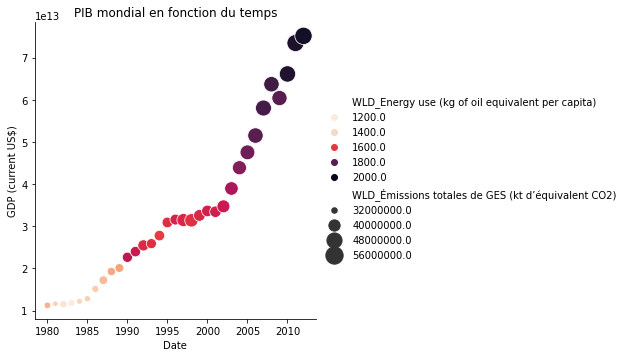

In [130]:
triplot_seaborn(dic['pib'], dic['ges'], var3 = dic['nrj_hab'], country_code = 'WLD',
                Titre =  'PIB mondial en fonction du temps')

Ici on peut voir l'évolution du PIB mondial en fonction du temps, dont la taille évolue de manière proportionnelle aux émissions mondiales de GES. On peut clairement voir que le PIB mondial n'a cessé de croître sur toutes la période, tout comme les émissions de gazs à effet de serre. 

Ce graphique explicite bien le fait stylisé que l'économie mondiale s'est développé en même temps que les émissions de gaz à effet de serre dûes à l'activité économique, et ce sans presque aucune interruption. 

On va regarder un pays développé en particuliers que l'on connait bien : la France

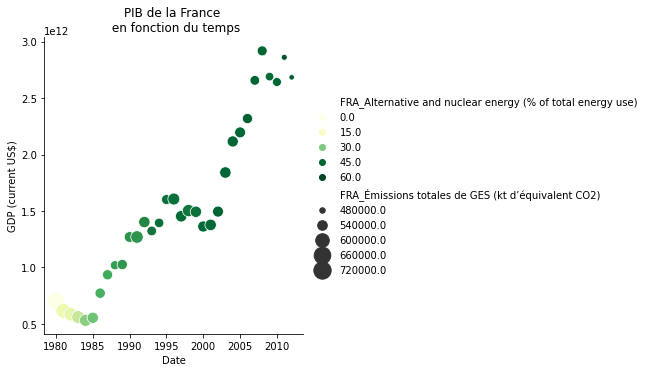

In [131]:
triplot_seaborn(dic['pib'], dic['ges'], 'FRA',
                'PIB de la France \n en fonction du temps',
                var3 =dic['clean_nrj'], color = 'YlGn' )

On observe dans le cas de la France que la croissance a pu se faire sans augmentation des émissions de GES, avec l'aide notamment du développement des énergies alternatives dans les années 1980, notamment le nucléaire

On va regarder un autre pays, la Chine, qui a réussi a fortement se développer économiquement sur la période.

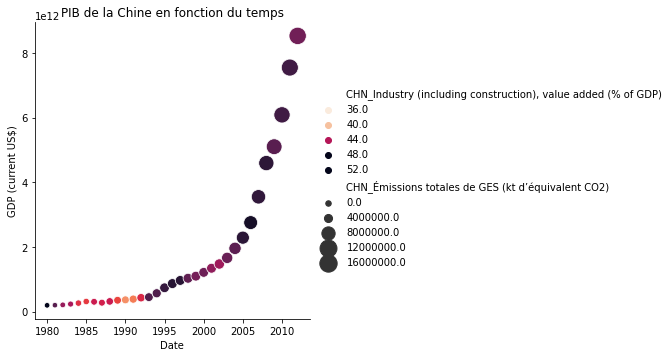

In [132]:
triplot_seaborn(dic['pib'], dic['ges'], 'CHN',
                'PIB de la Chine en fonction du temps',
                var3 =dic['industry'] )

Comme on peut le voir ici la Chine a fortement développé son industrie a partir des années 1980, ce qui a fait que celle-ci a gardé une part constante dans le PIB voir a même pris de l'importance alors même que le PIB de la Chine augmentait très fortement chaque année. De plus, on peut observer en parrallèle le développement des émissions de gazs à effet de serre de la Chine. 

Ce graphique nous montre bien un certain sentier de croissance suivi par la Chine, qui laisse une grande place à l'industrie fortement polluante et donc à l'émission de gazs à effet de serre.

On va comparer avec un autre pays au développement important, le Brésil.

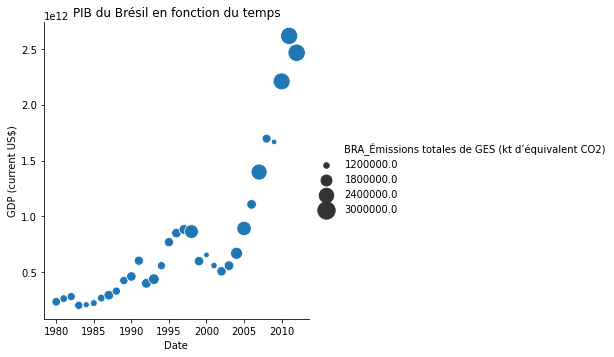

In [133]:
triplot_seaborn(dic['pib'], dic['ges'],'BRA', 'PIB du Brésil en fonction du temps')

Même si le Brésil n'a pas subi une industrialisation aussi lourde que la Chine on peut voir que ses émissions de gazs à effet de serre par habitant semblent assez volatiles. Il n'est pas certain que l'on ait une forte corrélation entre les émissions de GES et le PIB. 

Bien que la source soit fiable (Banque mondiale), on peut avoir un doute sur les données des émissions de GES : celles du Brésil semblent très volatiles, et on aurait des émissions nulles pour la Chine en 1980. On décide toutefois de les conserver puisque les tendances semblent cohérentes.

On cherche maintenant à représenter notre jeu de données sur une carte, afin de mieux visualiser nos données. On va pour cela définir les fonctions suivantes.

In [134]:
#La fonction intermédiaire que l'on utilise pour créer le géodataframe :
def create_gdf (df_geo,map_monde) :
    map_monde_clean = pd.DataFrame()
    map_monde_clean[['Country Code','geometry']] = map_monde[['iso_a3','geometry']].dropna()
    gdf = gpd.GeoDataFrame(df_geo.dropna().reset_index().merge(map_monde_clean,on = 'Country Code'),
                           geometry=df_geo.dropna()
                                       .reset_index()
                                       .merge(map_monde_clean,on = 'Country Code')['geometry'])
    return(gdf)

#La fonction pour passer nos valeurs au logarithme en base 10.
def log_norm (df_norm) :
    return(np.log10(df_norm.astype(np.float64)))


dic_pays = refresh_dico('Country Name','Country Code',df1)

#geoplot à utiliser das le cas d'une base avec des années (on a donc année et indic sur les lignes et années en colonnes)
def geo_plot (df,indic,annee,Titre = None,couleur = 'Oranges',norm=True, vmax= None, vmin = None) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe: 
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            _
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))
    if Titre != None :
        ax.set_title(Titre, fontsize = 20)

    gdf = create_gdf(df.loc[rech_ligne_indic(indic,df),['Country Code',annee]],map_monde)
    
    if norm :
        gdf[annee] = log_norm(gdf[annee])
    
    if vmax!= None :
        Norm = Normalize(vmin = vmin,vmax = vmax)
    if vmax == None :
        Norm = Normalize()
   
    gplt.choropleth(gdf,
                    hue = annee,
                    cmap = couleur,
                    legend=True,
                    norm = Norm,
                    ax=ax)
    plt.show()
    
#La fonction intermédiaire que l'on utilise pour créer le géodataframe :
def create_gdf (df_geo,map_monde) :
    map_monde_clean = pd.DataFrame()
    map_monde_clean[['Country Code','geometry']] = map_monde[['iso_a3','geometry']].dropna()
    gdf = gpd.GeoDataFrame(df_geo.dropna().reset_index().merge(map_monde_clean,on = 'Country Code'),
                           geometry=df_geo.dropna()
                                       .reset_index()
                                       .merge(map_monde_clean,on = 'Country Code')['geometry'])
    return(gdf)

#La fonction pour passer nos valeurs au logarithme en base 10.
def log_norm (df_norm) :
    return(np.log10(df_norm.astype(np.float64)))


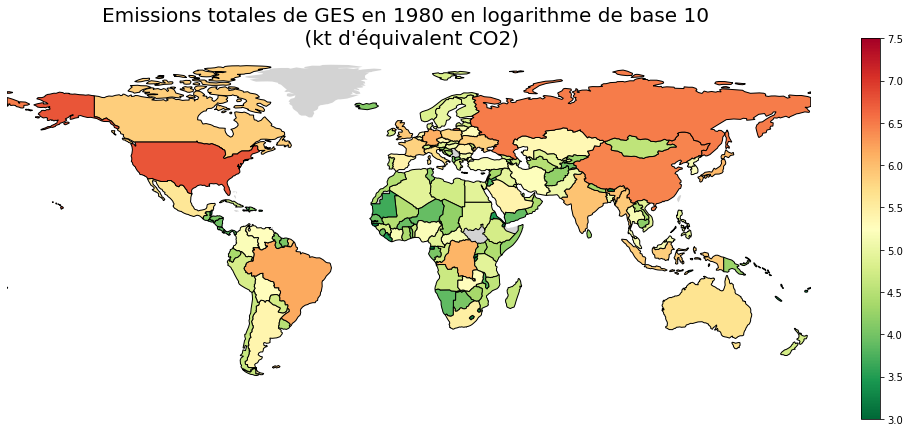

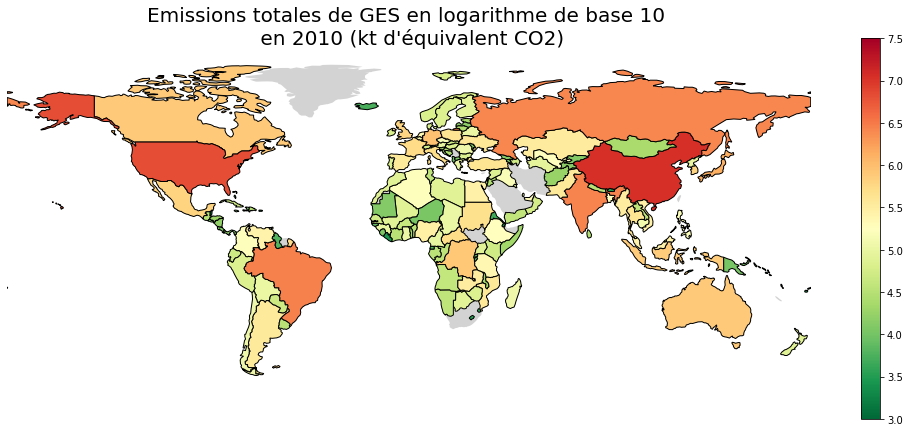

In [135]:
geo_plot(df1,
         'Émissions totales de GES \(kt d’équivalent CO2\)',
         '1980',
         Titre = 'Emissions totales de GES en 1980 en logarithme de base 10 \n (kt d\'équivalent CO2)',
         couleur = 'RdYlGn_r',
         norm=True,
         vmax =7.5,
         vmin =3)

geo_plot(df1,
         'Émissions totales de GES \(kt d’équivalent CO2\)',
         '2010',
         Titre = 'Emissions totales de GES en logarithme de base 10 \n en 2010 (kt d\'équivalent CO2)',
         couleur = 'RdYlGn_r',
         norm=True,
         vmax =7.5,
         vmin =3)

On retrouve une croissance globale des émissions de gaz à effet de serre. De plus, on observe que cette croissance est plus forte dans les pays dit "en développement", comme la Chine, le Brésil ou même l'Inde. 
On peut aussi voir une tendance globale à la hausse en Afrique. Les pays d'Europe quant à eux se maintiennent sur un niveau de gaz à effet de serre relativement élevé.
Cependant ces grandeurs sont à relativiser par la démographie respective des pays, ce que l'on va faire dans les prochains graphiques :

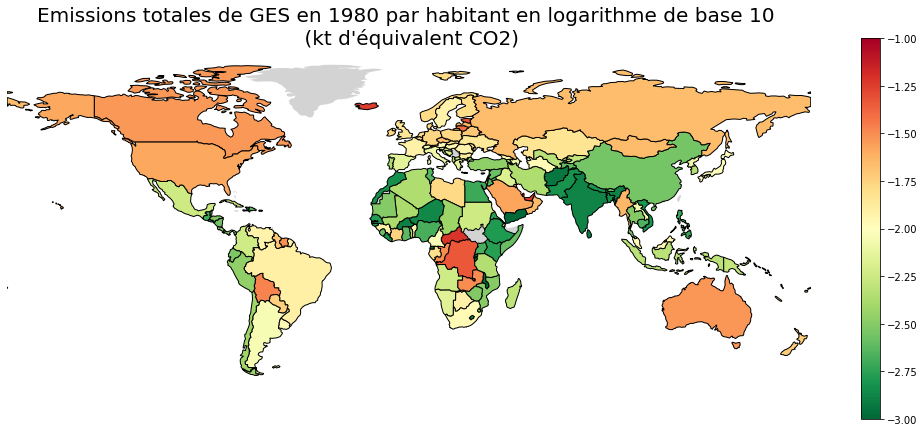

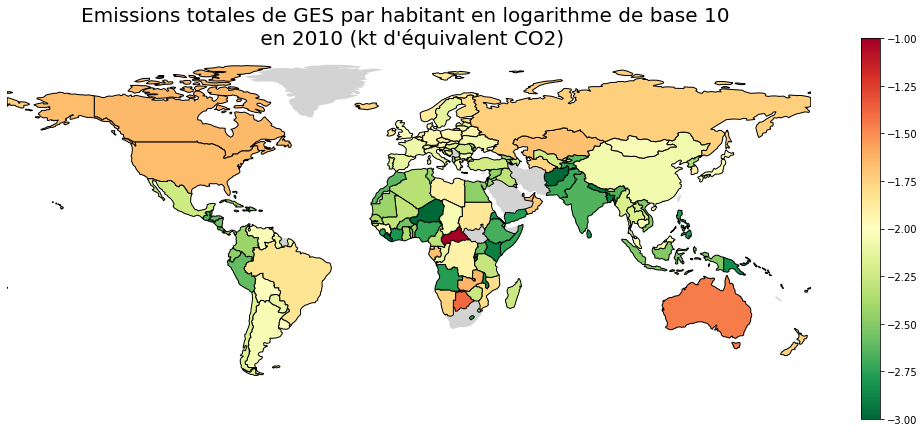

In [136]:
geo_plot(df1,
         'Émissions totales de GES \(kt d’équivalent CO2\) par Tete',
         '1980',
         Titre = 'Emissions totales de GES en 1980 par habitant en logarithme de base 10 \n (kt d\'équivalent CO2)',
         couleur = 'RdYlGn_r',
         norm=True,
         vmax =-1,
         vmin =-3)

geo_plot(df1,
         'Émissions totales de GES \(kt d’équivalent CO2\) par Tete',
         '2010',
         Titre = 'Emissions totales de GES par habitant en logarithme de base 10 \n en 2010 (kt d\'équivalent CO2)',
         couleur = 'RdYlGn_r',
         norm=True,
         vmax =-1,
         vmin =-3)

On peut voir ici qu'il y a une donnée aberrante avec la république centrafricaine, dans la mesure ou celle-ci n'est pas l'un des plus gros pollueurs et n'a pas uune population très faible sur la période, mais se retrouve être le pays avec le plus haut taux d'émission par tête sur la carte. Nous avons donc décidé de refaire la carte en abaissant le niveau afin de mieux se rendre compte des différences entre les autres pays.

On remarque que les pays en développement ou faisant partie des PMA émettent moins de gaz à effet de serre par habitant que les pays riches. Cepednant on observe un phénomène de rattrapage avec des pays comme la Chine, l'Inde et le Brésil qui augmente leurs émissions par habitant malgré l'augmentation de leur population sur la période. 
Au contraire, on observe que l'Europe a baissé ses émissions par rappor tà 1980. Les USA se maintiennent avec une légère baisse de leurs émissions dans la tête de liste des pays émetteurs. 

On remarque cependant que l'Australie est devant ceux-ci, et après avoir regardé en détail les données il semble qu'il y a eu un changement d'indicateur en 1996 qui a déclenché une brusque hausse des émissions observées. Cependant on observe une tendance relativement similaire sur les données pré et post changement. 

## Suppression des pays et agrégats non pertinents :

On va chercher à enlever les lignes qui ne contiennent que peu d'infos (au moins 10 valeurs manquantes) :

In [137]:
nan_dict = {}
for i in range(len(df1.index)) :
    nb_nan = df1.iloc[i].isnull().sum()
    if nb_nan >10 :
        nan_dict[list(df1.index)[i]] = nb_nan

df1 = df1.drop(index = nan_dict.keys(), axis = 0)
df1.shape

(2733, 43)

En faisant cela, on supprime environ 600 lignes.

In [138]:
dic_pays = refresh_dico('Country Name','Country Code',df1)

On a supprimer en tout 58 lignes. De plus on va aussi supprimer de la base les aggrégats de pays (ces lignes là sont colinéaires aux autres, ce qui risque de nous poser problème plus tard dans les modèles). On enlève de plus les pays dont on a vu qu'ils avaient des valeurs non pertinentes. Les régions que l'on va supprimer sont donc les suivantes : 

In [21]:
#/!\ il ne faut faire tourner qu'une seule fois cette fonction, sinon on a une KeyError
suppr_liste = ['Arab World', 'Le monde arabe', 'Central Europe and the Baltics', 'Europe centrale et les pays baltes',
 'Caribbean small states', 'Petits états des Caraïbes','East Asia & Pacific (excluding high income)', 
 'Asie de l’Est et Pacifique (hors revenu élevé)', 'Early-demographic dividend', 
 'de dividende précoce démographique', 'East Asia & Pacific', 'Asie de l’Est et Pacifique',
 'Europe & Central Asia (excluding high income)', 'Europe et Asie centrale (hors revenu élevé)',
 'Europe & Central Asia', 'Europe et Asie centrale',  'Euro area', 'Zone euro', 
 'European Union', 'Union européenne','Fragile and conflict affected situations',
 'Fragile et les situations de conflit touchées', 'High income',
 'Revenu élevé','Heavily indebted poor countries (HIPC)','Pays pauvres très endettés (PPTE)','IBRD only',
 'BIRD seulement','IDA & IBRD total',
 'BIRD et IDA',
 'IDA total',
 'IDA totale',
 'IDA blend',
 'IDA mélange','IDA only',
 'IDA seulement','Latin America & Caribbean (excluding high income)',
 'Amérique latine et Caraïbes (hors revenu élevé)','Latin America & Caribbean',
 'Amérique latine et Caraïbes',
 'Least developed countries: UN classification',
 'Pays les moins avancés\xa0: classement de l’ONU',
 'Low income',
 'Faible revenu','Lower middle income',
 'Revenu intermédiaire, tranche inférieure',
 'Low & middle income',
 'Revenu faible et intermédiaire','Late-demographic dividend',
 'de dividende tardif démographique','Middle East & North Africa',
 'Afrique du Nord et Moyen-Orient','Middle income',
 'Revenu intermédiaire', 'Middle East & North Africa (excluding high income)',
 'Afrique du Nord et Moyen-Orient (hors revenu élevé)','North America',
 'Amérique du Nord','OECD members',
 "Pays membres de l'OCDE",'Other small states',
 'Autres petits états','Pre-demographic dividend',
 'de Pré-dividende démographique', 'Pacific island small states',
 'Petits états insulaires du Pacifique',
 'Post-demographic dividend',
 'de Post-dividende démographique','South Asia',
 'Asie du Sud','Sub-Saharan Africa (excluding high income)',
 'Afrique subsaharienne (hors revenu élevé)',
 'Sub-Saharan Africa',
 'Afrique subsaharienne',
 'Small states',
 'Petits états','East Asia & Pacific (IDA & IBRD countries)',
 'Asie de l’Est et Pacifique (BIRD et IDA)',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Europe et Asie centrale (BIRD et IDA)','Latin America & the Caribbean (IDA & IBRD countries)',
 'Amérique latine et Caraïbes (BIRD et IDA)',
 'Middle East & North Africa (IDA & IBRD countries)',
 'Afrique du Nord et Moyen-Orient (BIRD et IDA)', 'South Asia (IDA & IBRD)',
 'Asie du Sud (BIRD et IDA)',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Afrique subsaharienne (BIRD et IDA)','Upper middle income',
 'Revenu intermédiaire, tranche supérieure','World',
 'Monde',
 'République centrafricaine','Central African Republic']


In [22]:
#Il ne faut pas faire tourner deux fois cette cellule 
for i in suppr_liste :
    df1 = df1.drop(labels = rech_ligne_pays(i,df1)) 
dic_pays = refresh_dico('Country Name','Country Code',df1)
df1.shape

(2135, 43)

In [23]:
data_csv=df1.to_csv('Complete_Data.csv',index=True)

On a supprimer en tout une centaine de lignes encore.

## Création de la base de données pour le Clustering :

Afin d'étudier les sentiers de croissance et leurs dépendances énergétiques, nous avons retenu trois catégories de variables :

    - La valeur en 2000, qui nous permet d'estimer de manière absolue la niveau des variables. L'année 2000 a été retenu car nous notre base manque de donnée au début des années 80 et après 2010 pour certains pays.
    
    -Le taux de variation moyen, qui nous donne une bonne estimation de l'évolution de la variable sur notre jeu de donnée.
    
    -le coefficient de la régression ainsi que son R² pour les variables qui nous ont parues pertinentes. On a décidé de prendre ces indicateurs pour avoir une idée de la relation entre ces deux grandeurs. Nous utilisons cette technique pour voir si les variations du PIB sontt corrélées à l'utilisation d'énergie, sans pour autant postuler que la nature de cette relation est une vraie dépendance de la production à l'énergie. Il s'agit davantage de se faire une idée du développement du pays, la nature de la relation entre les deux variables n'étant pas causales, ni même à sens unique.

On va chercher à créer la base avec les données qui nous intéressent pour la modélisation. Pour ça on définit les fonctions suivantes :


In [24]:
dic_code = refresh_dico('Country Code','Country Name',df1)
code_list = dic_code.keys()
def regress (country_code, regresseur, regresse) :
    
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)

        if interm.shape != (2,0): 
            x = sm.add_constant(interm.loc[country_code + regresseur].to_numpy())
            y = interm.loc[country_code + regresse].to_numpy()

            model = sm.OLS(y,x,'drop')
            results = model.fit()

            r2 = results.rsquared
            coef = results.params[1]

            return coef, r2
    
    else : return

On automatise aussi la récupération des coefficients sous forme de dictionnaire afin de pouvoir les inclure dans le dataframe.

In [25]:
def get_coeff (regresse, regresseur) :    
    dico = {}
    for code in code_list:
        dico[code] = regress(code,regresseur,regresse )
        if dico[code] == None:
            dico.pop(code)

    regress_df = pd.DataFrame(dico.values(), dico.keys(), ['Coefficient de ' + regresse + ' sur ' + regresseur,
                                                         'R2 de ' + regresse + ' sur ' + regresseur])
    return regress_df


On va aussi récupérer le taux de croissance moyen des économies sur la période :

In [26]:
def get_average_growth_rate(var) :
    dic = {}
    
    for country_code in dic_code.keys() : 
        if country_code + var in df1.index :    
            values = list(df1.loc[country_code + var][3:])
            values = [x for x in values if ~np.isnan(x)]
            initial_value = values[0]
            final_value = values[len(values)-1]
            variation_rate = (100 * ((final_value / initial_value))**(1/(len(values)-1))) - 100
            if variation_rate != np.inf :
                dic[country_code] = variation_rate
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['Average Growth Rate' + var])
    
    return(temp_df)

On récupère les valeurs en 2000 :

In [27]:
def get_2000(var):
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :
            dic[country_code] = df1.loc[country_code + var][23]
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['2000' + var])
    
    return(temp_df)

Enfin on créé la base de données avec tous les indicateurs :

In [28]:
data = get_average_growth_rate(dic['pib_hab'])

data_list = [get_average_growth_rate(dic['agr']), get_average_growth_rate(dic['industry']), 
            get_average_growth_rate(dic['ges_hab']), get_average_growth_rate(dic['clean_nrj']),
            get_average_growth_rate(dic['nrj_hab']), 
            get_2000(dic['pib_hab']), get_2000(dic['agr']), get_2000(dic['industry']),
            get_2000(dic['ges_hab']), get_2000(dic['clean_nrj']), get_2000(dic['nrj_hab']), 
            get_coeff(dic['pib_hab'], dic['ges_hab']),
            get_coeff(dic['pib_hab'], dic['nrj_hab'])]
for i in data_list :
    data = data.merge(i, how = 'outer', left_index = True, right_index = True)

C:\Users\SURFACE\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\SURFACE\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Après plusieurs essais, nous avons automatisé l'application de la méthode des K-means à un dataframe ne contenant pas de NaN.

Cette fonction normalise la base, applique la méthode des K-means, puis réalise une ACP sur la base afin d'obtenir une représentation en deux dimensions.
Elle peut optionnellement tracer le graphe de l'inertie du clustering en fonction du nombre de cluster, elle peut également représenter la part de la variance expliquée pour chaque vecteur propre de l'ACP.

In [29]:
def get_cluster_ACP(n_k_means, data, graph_ACP=False,to_normalize=True,graph_k_means=False,seed=False):
    #normalisation
    if to_normalize == True :
        data_norm = pd.DataFrame()
        for i in data.columns :
            data_norm[i] = preprocessing.scale(data[i])
            data_norm.index = data.index
    else : 
        data_norm=data
        
    #On crée le graphe du coude des clusters
    if graph_k_means==True:
        iner = []
        for k in range(2,10):
            result=data_norm.copy()
            centroid, appartenance, inertie = sklearn.cluster.k_means(data_norm, k)
            iner.append(inertie)
        plt.plot(np.linspace(2,9,num=8),iner)
        plt.title("Evolution de l'inertie en fonction du nombre de cluster")
        plt.show() 
    
    
    #graph ACP
    if graph_ACP==True:
        
        PCA = sklearn.decomposition.PCA(10)
        PCA.fit(data_norm)

        res = PCA.explained_variance_ratio_

        t=np.linspace(1,10,num=10)
        plt.plot(t,PCA.explained_variance_ratio_*100)
        plt.title("Part de la variance expliquée sur chaque axe de l'ACP")
        plt.show()

    #on enregistre dans la base les centroïdes
    result=data_norm.copy()
    if seed != False:
        centroid, result['Cluster'], inertie = sklearn.cluster.k_means(data_norm, n_k_means,random_state=seed)
    else :
        centroid, result['Cluster'], inertie = sklearn.cluster.k_means(data_norm, n_k_means)
    for i in range(0,n_k_means):
        result.loc['Centroid '+str(i)] = np.concatenate((centroid[i],np.array([i])))
    
     
        
    #Application de l'ACP
    PCA = sklearn.decomposition.PCA(2)
    PCA.fit(data_norm)
    data_ds_acp = PCA.transform(data_norm)
    result_ACP = pd.DataFrame(data_ds_acp)
    
    #Enregistrement des données de l'ACP
    data_norm.loc['axis_1']=PCA.components_[0]
    data_norm.loc['axis_2']=PCA.components_[1]
    PCA_axis=data_norm.loc[['axis_1','axis_2']]
    
    #représentation graphique des clusters dans l'ACP
    result_ACP.index = result.index[:-n_k_means]
    result_ACP['Cluster'] = result['Cluster'][:-n_k_means]
    
    f = go.FigureWidget([go.Scatter(x=list(result_ACP[0]), 
                                y=list(result_ACP[1]), 
                                text=list(dic_code[i] for i in result_ACP.index),
                                mode='markers',
                                hoverinfo='text')])
    scatter = f.data[0]
    colormap = np.array(['black','red','royalblue','forestgreen','gold','silver','darkgoldenrod','deeppink','mediumturquoise','orange','firebrick'])
    f.layout.title = 'Représentation des '+str(n_k_means)+' clusters dans le plan de l\'ACP'
    f.layout.title.x = 0.5
    f.layout.title.y = 0.88
    f.layout.titlefont.size = 28
    
    scatter.marker.color = colormap[result_ACP['Cluster'].astype(int).to_numpy()]
    scatter.marker.size = [10] * len(result_ACP.index)
    f.layout.hovermode = 'closest'
    
    #plt.title("Représentation des clusters dans L'ACP")
    f.show()
    
    dic_cluster={}
    for i in range (n_k_means):
        dic_cluster['Cluster'+str(i)]=list(result.where(result['Cluster'] == i).dropna().index[:-1])
        dic_cluster['Cluster'+str(i)].append(colormap[i])

        
    return result,dic_cluster,PCA_axis

A notre première tentative, nous avons appliqué cette méthode sur notre base où avons supprimé tous les pays dont il manquait un indicateur

In [30]:
data_1=data.dropna(axis=0)
print(data_1.shape,data.shape)

(60, 16) (198, 16)


**Il est à noter que la base de données a été fortement réduite car nous avons conservé beaucoup d'indicateurs, ce qui a entrainé la suppression de nombreux pays pour lesquels des données étaient manquantes.
Cela va rendre nos résultats moins robustes et moins significatifs, nous allons donc plus tard essayer d'enlever certains indicateurs pour aggrandir la base de données et voir si on retrouve des groupes semblables.**

### Etude descriptive rapide de la nouvelle base constituée :

On va calculer la moyenne des indicateurs sur l'ensemble des pays dans la base afin d'obtenir un point de référence dans nos futurs analyses sur cette base précisément : 

In [31]:
Des = pd.DataFrame(list(data_1[i].mean() for i in data_1.columns),data_1.columns)
Des['Var'] = list(data_1[i].var() for i in data_1.columns)

In [32]:
Des

0  \
Average Growth Rate_GDP (current US$) par Tete           4.037374   
Average Growth Rate_Agriculture, forestry, and ...      -2.251383   
Average Growth Rate_Industry (including constru...      -0.171124   
Average Growth Rate_Émissions totales de GES (k...       0.003190   
Average Growth Rate_Alternative and nuclear ene...       1.526655   
Average Growth Rate_Energy use (kg of oil equiv...       0.984333   
2000_GDP (current US$) par Tete                       7117.808619   
2000_Agriculture, forestry, and fishing, value ...      12.742339   
2000_Industry (including construction), value a...      29.277680   
2000_Émissions totales de GES (kt d’équivalent ...       0.008188   
2000_Alternative and nuclear energy (% of total...       7.621772   
2000_Energy use (kg of oil equivalent per capita)     1599.184106   
Coefficient de _GDP (current US$) par Tete sur ... -680064.717060   
R2 de _GDP (current US$) par Tete sur _Émission...       0.381926   
Coefficient de _GDP (current US$) par Tete sur ...       7.650008   
R2 de _GDP (current US$) par Tete sur _Energy u...       0.565502   

                                                             Var  
Average Growth Rate_GDP (current US$) par Tete      3.157090e+00  
Average Growth Rate_Agriculture, forestry, and ...  2.057566e+00  
Average Growth Rate_Industry (including constru...  1.213523e+00  
Average Growth Rate_Émissions totales de GES (k...  3.380726e+00  
Average Growth Rate_Alternative and nuclear ene...  1.531604e+01  
Average Growth Rate_Energy use (kg of oil equiv...  1.751662e+00  
2000_GDP (current US$) par Tete                     1.089544e+08  
2000_Agriculture, forestry, and fishing, value ...  1.142384e+02  
2000_Industry (including construction), value a...  1.034751e+02  
2000_Émissions totales de GES (kt d’équivalent ...  7.950140e-05  
2000_Alternative and nuclear energy (% of total...  1.141020e+02  
2000_Energy use (kg of oil equivalent per capita)   2.705345e+06  
Coefficient de _GDP (current US$) par Tete sur ...  3.390123e+13  
R2 de _GDP (current US$) par Tete sur _Émission...  1.035006e-01  
Coefficient de _GDP (current US$) par Tete sur ...  1.368770e+02  
R2 de _GDP (current US$) par Tete sur _Energy u...  8.369571e-02

On observe donc sur la période une croissance du PIB par tête sur la période, et une baisse significative du secteur de l'agriculture en terme de part de PIB. On peut observer aussi une augmentation importante de la part des énergies alternatives et nucléaires au sein du mix énergétique du pool de pays. On a aussi une augmentation de l'énergie consommée par tête sur la période.

# Modélisation :

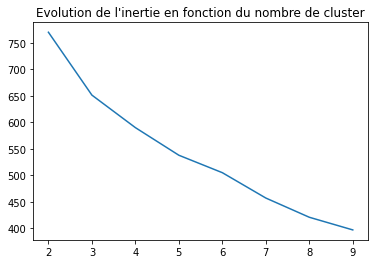

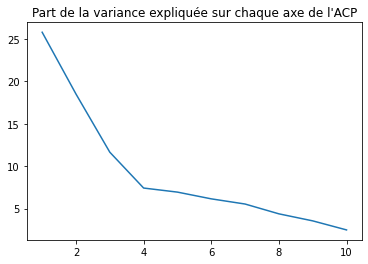

In [33]:
A,dic,axis=get_cluster_ACP(3,data_1,graph_ACP=True,graph_k_means=True,seed=1)

Dans un souci de visualisation, nous avons choisi de nous limiter au deux premiers axes de l'ACP, qui expliquent environ 45 % de la variance de notre jeu de donnée. On peut afficher axis pour les interpréter :

In [34]:
axis

Average Growth Rate_GDP (current US$) par Tete  \
axis_1                                       -0.083922   
axis_2                                        0.417687   

        Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)  \
axis_1                                          -0.113444                                
axis_2                                          -0.243149                                

        Average Growth Rate_Industry (including construction), value added (% of GDP)  \
axis_1                                          -0.242245                               
axis_2                                          -0.188613                               

        Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
axis_1                                          -0.180743                             
axis_2                                           0.329397                             

        Average Growth Rate_Alternative and nuclear energy (% of total energy use)  \
axis_1                                           0.068738                            
axis_2                                           0.033347                            

        Average Growth Rate_Energy use (kg of oil equivalent per capita)  \
axis_1                                          -0.233689                  
axis_2                                           0.410420                  

        2000_GDP (current US$) par Tete  \
axis_1                         0.432991   
axis_2                         0.111488   

        2000_Agriculture, forestry, and fishing, value added (% of GDP)  \
axis_1                                          -0.310303                 
axis_2                                          -0.292115                 

        2000_Industry (including construction), value added (% of GDP)  \
axis_1                                          -0.036326                
axis_2                                           0.183203                

        2000_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
axis_1                                           0.226164              
axis_2                                           0.008673              

        2000_Alternative and nuclear energy (% of total energy use)  \
axis_1                                           0.372706             
axis_2                                           0.069575             

        2000_Energy use (kg of oil equivalent per capita)  \
axis_1                                           0.418256   
axis_2                                           0.163092   

        Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
axis_1                                          -0.315826                                                         
axis_2                                           0.077947                                                         

        R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
axis_1                                           0.005593                                                
axis_2                                           0.370132                                                

        Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)  \
axis_1                                           0.011666                                              
axis_2                                           0.193883                                              

        R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)  
axis_1                                          -0.281782                                    
axis_2                                           0.330574

Les pays à droite dans ce plan sont, grossièrement, les pays dont les indicateurs économiques sont significativement au-dessus de la moyenne en 2000, et dont le rythme de croissance de nos indicateurs est plutôt inférieur à la moyenne. Les pays plutôt en haut, quand à eux, sont ceux dont la croissance a été très au-dessus de la moyenne, ce qui passe par une forte consommation d'énergie. Certte dernière est pour eux assez corrélée avec l'augmentation de la production, d'après les coefficients de régression et les R² associés.

In [35]:
A.tail(3)

Average Growth Rate_GDP (current US$) par Tete  \
Centroid 0                                       -0.149869   
Centroid 1                                        0.662221   
Centroid 2                                       -0.478530   

            Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)  \
Centroid 0                                          -0.287462                                
Centroid 1                                          -0.369528                                
Centroid 2                                           0.418211                                

            Average Growth Rate_Industry (including construction), value added (% of GDP)  \
Centroid 0                                          -0.779616                               
Centroid 1                                          -0.068925                               
Centroid 2                                           0.373782                               

            Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                          -0.510795                             
Centroid 1                                           0.732833                             
Centroid 2                                          -0.389021                             

            Average Growth Rate_Alternative and nuclear energy (% of total energy use)  \
Centroid 0                                           0.412393                            
Centroid 1                                          -0.149695                            
Centroid 2                                          -0.046038                            

            Average Growth Rate_Energy use (kg of oil equivalent per capita)  \
Centroid 0                                          -0.718084                  
Centroid 1                                           0.893346                  
Centroid 2                                          -0.435359                  

            2000_GDP (current US$) par Tete  \
Centroid 0                         1.721108   
Centroid 1                        -0.302165   
Centroid 2                        -0.454984   

            2000_Agriculture, forestry, and fishing, value added (% of GDP)  \
Centroid 0                                          -0.883848                 
Centroid 1                                          -0.140460                 
Centroid 2                                           0.474536                 

            2000_Industry (including construction), value added (% of GDP)  \
Centroid 0                                          -0.371547                
Centroid 1                                           0.091702                
Centroid 2                                           0.076651                

            2000_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.900930              
Centroid 1                                          -0.338126              
Centroid 2                                          -0.091535              

            2000_Alternative and nuclear energy (% of total energy use)  \
Centroid 0                                           1.369394             
Centroid 1                                          -0.220337             
Centroid 2                                          -0.378367             

            2000_Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           1.774649   
Centroid 1                                          -0.303177   
Centroid 2                                          -0.475972   

            Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                          -1.322678                                                         
Centroid 1                                

Après de multiples essais, nous en sommes arrivés à la conclusion que les meilleurs clusters stables sont ceux ci-dessus. En effet, nous avons remarqué que lorsque le nombre de cluster augmentait, les clusters étaient plus précis mais ne se retrouvaient pas nécessairement d'une fois sur l'autre. Nous avons donc choisi de nous concentrer sur les clusters suffisamment reconnaissables par l'algorythme pour rester stable, gage de significativité du cluster.

On retrouve très clairement trois catégories de pays :

-Les pays de l'OCDE, en rouge, associé au Centroïde 1, caractérisés par une croissance du PIB faible, une tendance à la baisse des secteurs industriels et agricoles, une taux de variation de la production énergétique étonnamment bas, et des valeurs en 2000 plus importantes que la moyenne, et une décorrélation du PIB aux émissions de GES et à la production énergétique.

-Les pays les moins développés, en bleu, associé au Centroïde 2, qui ont pour caractéristiques communes des indicateurs de faible valeur en ce qui concerne le PIB, l'énergie, l'émission de GES, la part d'énergie renouvelable et nucléaire, et une part importante de l'agriculture et de l'industrie dans le PIB. On retrouve également pour ces pays-là une faible corrélation du PIB à la croissance énergétique et aux émission de GES.

-Les pays en cours de développement, en noir, associé au Centroïde 0. Ces derniers se distinguent par une forte croissance du PIB, des émissions de GES et du secteur énergétique, bien que leurs valeurs nominales soient inférieures à celles de l'OCDE. Pour ce cluster, le PIB est corrélé de manière significative au émissions de GES et à la croissance énergétique.

### Suppression de certains indicateurs pour augmenter le jeu de donnée, et clustering sur cette nouvelle base

 Dans le but de rendre notre modèle plus pertinent par le biais d'un échantillon plus représentatif, nous avons choisi de faire entrer de nouveaux pays en éliminant certains indicateurs pour lesquels nous avions essentiellement des données sur les pays riches.

In [36]:
data_2=data.drop(['Average Growth Rate_Alternative and nuclear energy (% of total energy use)','Average Growth Rate_Energy use (kg of oil equivalent per capita)',
                '2000_Energy use (kg of oil equivalent per capita)','2000_Alternative and nuclear energy (% of total energy use)',
                'Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)',
                'R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)'],axis=1)

In [37]:
data_2=data_2.dropna(axis=0)
data_2.shape

(108, 10)

Grâce à cette modification de la conception de notre base, nous l'avons étendu à 108 pays, ce qui est plus pertinent pour faire du clustering. C'est ce que nous faisons maintenant

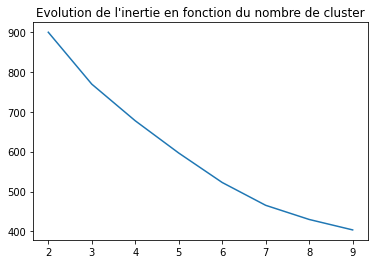

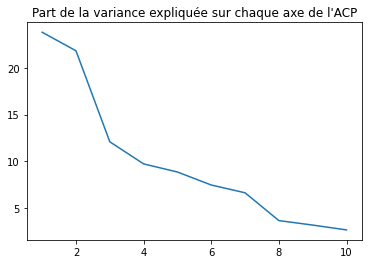

In [38]:
A,dic,axis=get_cluster_ACP(2,data_2,graph_ACP=True,graph_k_means=True)

Cette fois-ci, on voit clairement un "coude" dans le graphe de l'ACP, et on voit que les deux premiers axes permettent de rerésenter près de 50% de la variance totale, ce qui nous indique que notre représentation graphique est de qualité très correcte. En revanche, il est toujours aussi difficile de déterminer un nombre de cluster pertinent en se fondant sur l'inertie intraclasse. Comme l'analyse des axes n'apporte pas grand chose de plus que celle des clusters, nous ne l'effectuons plus à partir de maintenant.

In [39]:
A,dic,axis=get_cluster_ACP(5,data_2, seed = 5)

In [40]:
A.tail()

Average Growth Rate_GDP (current US$) par Tete  \
Centroid 0                                       -0.077606   
Centroid 1                                       -0.643623   
Centroid 2                                        1.034071   
Centroid 3                                        0.884699   
Centroid 4                                       -0.228290   

            Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)  \
Centroid 0                                          -0.360893                                
Centroid 1                                           0.769280                                
Centroid 2                                          -0.387595                                
Centroid 3                                          -0.794461                                
Centroid 4                                          -0.100091                                

            Average Growth Rate_Industry (including construction), value added (% of GDP)  \
Centroid 0                                          -0.385975                               
Centroid 1                                           0.212445                               
Centroid 2                                           0.610581                               
Centroid 3                                           0.595429                               
Centroid 4                                          -0.609938                               

            Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                          -0.197545                             
Centroid 1                                          -0.283431                             
Centroid 2                                           0.951893                             
Centroid 3                                           0.272024                             
Centroid 4                                          -0.539032                             

            2000_GDP (current US$) par Tete  \
Centroid 0                        -0.300392   
Centroid 1                        -0.542388   
Centroid 2                        -0.301435   
Centroid 3                         1.167447   
Centroid 4                         2.282571   

            2000_Agriculture, forestry, and fishing, value added (% of GDP)  \
Centroid 0                                          -0.480101                 
Centroid 1                                           1.135296                 
Centroid 2                                          -0.070404                 
Centroid 3                                          -1.235619                 
Centroid 4                                          -1.102016                 

            2000_Industry (including construction), value added (% of GDP)  \
Centroid 0                                           0.529724                
Centroid 1                                          -0.592906                
Centroid 2                                          -0.125954                
Centroid 3                                           1.659612                
Centroid 4                                           0.128125                

            2000_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.174455              
Centroid 1                                          -0.358615              
Centroid 2                                          -0.490837              
Centroid 3                                          -0.816174              
Centroid 4                                           1.230458              

            Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                          -0.072639                                                         
Centroid 1                                    

Si l'on garde 5 clusters, on arrive à identifier un motif qui se répète assez souvent. Il s'agit de celui inidqué ci-dessus, avec une seed égale à 5. 

    -Le cluster 0, en noir, correspond à des pays de niveau de développement intermédiaire, dont la croissance de l'ensemble des indicateurs était inféreure à la moyenne. Il s'agit de pays dont le secteur agricole, contrairement au secteur industriel, était assez peu développé en 2000.
    
    -Le cluster 1 regroupe des pays peu développés : ils sont fortement agricole, leur croissance est faible, et leur agriculture (et dans une moindre mesure leur industrie) représentent une part plus importante de leur PIB que dans les autres pays. 
    
    -Le cluster 2 correspond aux pays qui se sont beaucoup développé sur la période, notamment à l'aide d'un accroissement de l'émission de GES assez marqué, leur PIB y étant significativement dépendant.
    
    -Le cluster 3  ne concerne que Puerto Rico, qui est une valeur assez singulière dans cette base. Il s'agit d'une valeur isolée, et sans l'isoler dans un cluster on rend le reste du modèle instable en déplaçant l'un des centroïdes vers un point non pertinent. Ainsi, si l'on ne garde que quatre clusters, leur structure est très instable. Puerto Rico a notamment une valeur presque aberrante en ce qui concerne le coefficient de régression du PIB sur l'émission de GES.
    
    - Le dernier centroïde regroupe les pays qui polluaient beaucoup en 2000, et qui avaient un PIB très supérieur à la moyenne. Avec une croissance faible de l'industrie et un secteur industriel peu important et stagnant, il s'agit peu ou prou des pays industriels développés occidentaux.
    
Cette analyse à cinq clusters reste assez peu stable, mais elle permet de raffiner un peu l'analyse contrairement aux analyses avec moins de clusters. Celle en deux cluster oppose les pays développés (caricaturalement les pays occidentaux) aux pays en cours de développement. Et celle à trois clusters conserve un cluster pays développé (très stable quelque soit le nombre de clusters) et divise le cluster des pays moins développés entre ceux qui ont eu une forte croissance et ceux qui restent encore peu avanccés. On met les graphiques ci-dessous :

In [41]:
A,dic,axis=get_cluster_ACP(3,data_2, seed = 0)

### On refait une analyse en conservant les variables sur l'énergie, mais en supprimant celles sur les secteurs d'activité

On a réussi à obtenir des résultats sur un échantillon plus grand, mais en supprimant certaines variables qui nous intéressaient, puisqu'eles portaient sur l'énergie. On cherche à voir si on peut retrouver ces résultats en conservant ces données, mais en supprimant celles portant sur les secteurs d'activité afin d'avoir un échantilllon plus important.

In [42]:
data_set_3=data.drop(['Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)',
                  'Average Growth Rate_Industry (including construction), value added (% of GDP)',
                  '2000_Agriculture, forestry, and fishing, value added (% of GDP)',
                  '2000_Industry (including construction), value added (% of GDP)'],axis=1)
data_set_3=data_set_3.dropna()
data_set_3.shape

(83, 12)

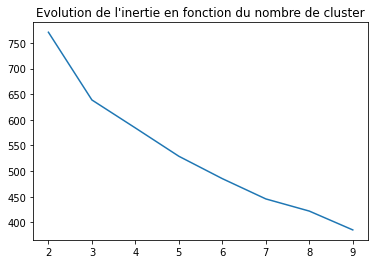

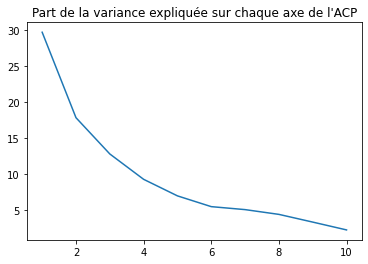

Average Growth Rate_GDP (current US$) par Tete  \
Centroid 0                                       -0.032877   
Centroid 1                                        0.103563   

            Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.162495                             
Centroid 1                                          -0.511860                             

            Average Growth Rate_Alternative and nuclear energy (% of total energy use)  \
Centroid 0                                          -0.153698                            
Centroid 1                                           0.484147                            

            Average Growth Rate_Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.192802                  
Centroid 1                                          -0.607328                  

            2000_GDP (current US$) par Tete  \
Centroid 0                        -0.423785   
Centroid 1                         1.334922   

            2000_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                          -0.290479              
Centroid 1                                           0.915010              

            2000_Alternative and nuclear energy (% of total energy use)  \
Centroid 0                                          -0.337943             
Centroid 1                                           1.064519             

            2000_Energy use (kg of oil equivalent per capita)  \
Centroid 0                                          -0.456026   
Centroid 1                                           1.436481   

            Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.340847                                                         
Centroid 1                                          -1.073667                                                         

            R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                          -0.059428                                                
Centroid 1                                           0.187199                                                

            Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.106858                                              
Centroid 1                                          -0.336601                                              

            R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.238801                                     
Centroid 1                                          -0.752222                                     

            Cluster  
Centroid 0      0.0  
Centroid 1      1.0

In [43]:
A,dic,axis=get_cluster_ACP(2,data_set_3,graph_k_means=True,graph_ACP=True)
A.tail(2)

En ce qui concerne l'ACP, notre premier axe permet d'expliquer une grande part de la variance, et le deuxième apporte une contribution honorable. Notre représentation graphique devrait donc avoir du sens.
En revanche, il est toujours difficile de trouver un bon nombre de clusters en se basant sur l'inertie intraclasse.

On retrouve deux clusters la séparation entre pays riches et polluants d'une part, et les pays en cours de développement d'auttre part. Un des facteurs de séparation est toutefois la corrélation entre consommation d'énergie et niveau de PIB. On voit ici que le centroïde correspondant au cluster des pays développés à des coefficients assez négatifs en ce qui concerne les coefficients des régressions, ainsi que le R² de la seconde régression. On voit donc que la production des pays développés est moins corrélée que celle des autres pays aux énergies utilisées, ainsi qu'à la quantité de GES émise. On pourrait expliquer cela par un niveau de développement plus avancé et donc à la fois une économie déjà assez industrialisée et surtout une part d'énergie alternative significativement au-dessus de la moyenne.

Ce dernier résultat est donc assez solide, puisqu'on le retrouve avec toutes nos bases jusqu'à présent. On va chercher à voir, avec plus de clusters, s'il est possible de raffiner cette analyse au niveau des pays en développement.

In [44]:
A,dic,axis=get_cluster_ACP(4,data_set_3, seed = 2)
A.tail()

Average Growth Rate_GDP (current US$) par Tete  \
ZWE                                              -1.583939   
Centroid 0                                        0.414149   
Centroid 1                                        0.043497   
Centroid 2                                       -0.493241   
Centroid 3                                        0.160273   

            Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
ZWE                                                  1.138460                             
Centroid 0                                           0.697802                             
Centroid 1                                          -0.275052                             
Centroid 2                                          -0.420883                             
Centroid 3                                          -0.653178                             

            Average Growth Rate_Alternative and nuclear energy (% of total energy use)  \
ZWE                                                 -0.809659                            
Centroid 0                                          -0.085158                            
Centroid 1                                          -0.277375                            
Centroid 2                                          -0.165708                            
Centroid 3                                           1.063573                            

            Average Growth Rate_Energy use (kg of oil equivalent per capita)  \
ZWE                                                 -0.703159                  
Centroid 0                                           0.895290                  
Centroid 1                                          -0.133879                  
Centroid 2                                          -0.562118                  
Centroid 3                                          -0.988485                  

            2000_GDP (current US$) par Tete  \
ZWE                               -0.701315   
Centroid 0                        -0.401005   
Centroid 1                         1.484689   
Centroid 2                        -0.546538   
Centroid 3                         1.492793   

            2000_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
ZWE                                                 -0.550794              
Centroid 0                                          -0.405032              
Centroid 1                                           1.329717              
Centroid 2                                          -0.183584              
Centroid 3                                           0.535497              

            2000_Alternative and nuclear energy (% of total energy use)  \
ZWE                                                 -0.388534             
Centroid 0                                          -0.330366             
Centroid 1                                           0.821576             
Centroid 2                                          -0.319113             
Centroid 3                                           1.224845             

            2000_Energy use (kg of oil equivalent per capita)  \
ZWE                                                 -0.553108   
Centroid 0                                          -0.419680   
Centroid 1                                           1.753679   
Centroid 2                                          -0.519791   
Centroid 3                                           1.200649   

            Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
ZWE                                                  0.105128                                                         
Centroid 0                                           0.498320                                                         
Centroid 1                                          -0.435808                                                         
Centroid 2  

Avec trois clusters, on a tendance à retrouver la même partition que dans notre modèle précédent.Les pays développés restent dans un même cluster. Les pays qui ont eu un rattrapage dans le développement qui est passé par une forte utilisation d'énergie et une forte émission de GES forment un second cluster, et les pays dont le développement est moins marqué forment un troisième cluster.

En revanche, la structure à quatre cluster que l'on retrouve avec la seed 2 est assez récurrente, et permet de faire une distinction supplémentaire parmi les pays développés au prix d'une plus forte instabilité de la séparation entre les deux clusters des pays en développement. 

Le cluster 2 est un cluster où les pays ont une évolution moins importante de l'utilisation de l'énergie que les autres pays développés. L'évolution de leurs émissions est en moyenne inférieur aussi, et au contraire il s'agit de pays qui ont beaucoup développé leur utilisation d'énergies alternatives sur la période même si en 2000 elle restait plus faible. Si l'on regarde les coefficients de nos régressions, il s'agit de pays dont la production est beaucoup moins dépendante de la consommation d'énergie que les autres. C'est la première fois que l'on arrive à obtenir ces résultats, mais ils ne sont pas totalement stable. De plus, on peut s'étonner de retrouver des pays comme l'Allemagne ou les USA dans ce cluster des pays "modèles" en terme d'élasticité énergétique de la croissance.

## Analyse centrée sur les évolutions : 

Pour se concentrer davantage sur ces sentiers de croissance, on décide de ne plus conserver les valeurs de nos variables en 2000. On espère voir davantage les clusters se concentrer sur les évolutions, et peut-être ne plus voir systématiquement apparaitre un cluster de pays riches. En revanche, comme on conserve tous nos indicateurs pour ce faire, on se retrouve sur une base avec seulement les 60 pays initiaux.

In [45]:
data_set_4=data.drop(['2000_GDP (current US$) par Tete',
                      '2000_Émissions totales de GES (kt d’équivalent CO2) par Tete',
                      '2000_Agriculture, forestry, and fishing, value added (% of GDP)',
                      '2000_Industry (including construction), value added (% of GDP)',
                      '2000_Alternative and nuclear energy (% of total energy use)',
                      '2000_Energy use (kg of oil equivalent per capita)'],axis=1)
data_set_4=data_set_4.dropna()
data_set_4.shape

(61, 10)

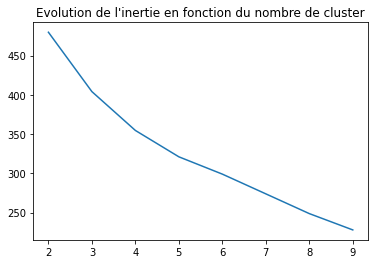

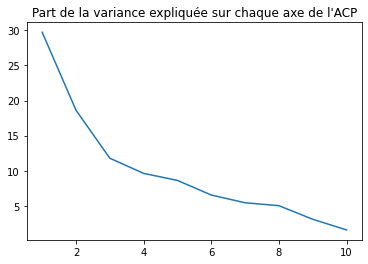

Average Growth Rate_GDP (current US$) par Tete  \
Centroid 0                                        0.582441   
Centroid 1                                       -0.462527   

            Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)  \
Centroid 0                                          -0.246159                                
Centroid 1                                           0.195479                                

            Average Growth Rate_Industry (including construction), value added (% of GDP)  \
Centroid 0                                          -0.004124                               
Centroid 1                                           0.003275                               

            Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.601804                             
Centroid 1                                          -0.477903                             

            Average Growth Rate_Alternative and nuclear energy (% of total energy use)  \
Centroid 0                                           0.002296                            
Centroid 1                                          -0.001823                            

            Average Growth Rate_Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.821182                  
Centroid 1                                          -0.652115                  

            Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.439160                                                         
Centroid 1                                          -0.348745                                                         

            R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.550395                                                
Centroid 1                                          -0.437078                                                

            Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.178351                                              
Centroid 1                                          -0.141631                                              

            R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.850489                                     
Centroid 1                                          -0.675388                                     

            Cluster  
Centroid 0      0.0  
Centroid 1      1.0

In [46]:
A,dic,axis=get_cluster_ACP(2,data_set_4,graph_ACP=True,graph_k_means=True)
A.loc[['Centroid 0', 'Centroid 1']]

La représentation dans le plan de l'ACP semble une nouvelle fois relativement fiable au vu de la varaince expliquée par les deux premiers axes (surtout par le premier). 

Il est toujours aussi difficile en revanche de trouver un nombre de cluster optimal par cette méthode de l'inertie intraclasse.

Cette fois-ci, lorsque l'on partitionne nos données en deux clusters, la distinction ne se fait plus selon le niveau des variables en 2000. Il s'agit au contraire de regrouper les pays qui ont eu une forte croissance, basée sur l'augmentation de l'utilisation de l'énergie par tête et des émission de GES. On retrouve ainsi des coefficients relativement importants et significatifs en ce qui concerne la régression linéaire du PIB sur ces deux indicateurs. En revanche, leur industrie et leur développement des énergies alternatives ne sont que proches de la moyenne, et le développement de l'agriculture un peu en-dessous. Le second cluster représente les pays qui ont une trajectoire exactement inverse.

On regarde si on peut raffiner un peu plus.

In [47]:
A,dic,axis=get_cluster_ACP(3,data_set_4, seed = 1)
A.tail(3)

Average Growth Rate_GDP (current US$) par Tete  \
Centroid 0                                       -0.343675   
Centroid 1                                        0.749443   
Centroid 2                                       -0.399811   

            Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)  \
Centroid 0                                           0.599233                                
Centroid 1                                          -0.424176                                
Centroid 2                                          -0.406081                                

            Average Growth Rate_Industry (including construction), value added (% of GDP)  \
Centroid 0                                          -0.206234                               
Centroid 1                                           0.051364                               
Centroid 2                                           0.258036                               

            Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                          -0.373849                             
Centroid 1                                           0.779173                             
Centroid 2                                          -0.389827                             

            Average Growth Rate_Alternative and nuclear energy (% of total energy use)  \
Centroid 0                                           0.001698                            
Centroid 1                                          -0.127302                            
Centroid 2                                           0.156474                            

            Average Growth Rate_Energy use (kg of oil equivalent per capita)  \
Centroid 0                                          -0.115952                  
Centroid 1                                           0.974032                  
Centroid 2                                          -1.036365                  

            Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                          -0.071119                                                         
Centroid 1                                           0.495347                                                         
Centroid 2                                          -0.508061                                                         

            R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                          -0.627060                                                
Centroid 1                                           0.991682                                                
Centroid 2                                          -0.259822                                                

            Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.617787                                              
Centroid 1                                           0.144137                                              
Centroid 2                                          -1.145464                                              

            R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.171483                                     
Centroid 1                                           0.854572                                     
Centroid 2                                          -1.336157                                     

            Cluster  
Centroid 0      0.0  
Centroid 1      1.0  
Centroid 2      2.0

La structure à trois clusters est relativement stable aussi, on identifie trois groupes de pays relativement stables, avec seulement quatre ou cinq pays qui changent de groupes d'une fois sur l'autre. Ici, avec la graine 1, cela donne :

Le cluster 0 comprend les pays qui ont une croissance économique relativement lente, avec notamment une agriculture peu dynamique. Il s'agit surtout d'un groupe de pays où l'utilisation d'énergie, et dans une moindre mesure les émissions de GES, croissent moins vite que dans les autres pays. On y voit que le PIB ne dépend que très peu de l'utilisation d'énergie ou de la production de GES. Il s'agit donc de pays ayant pour la plupart atteint un niveau de développement assez élevé (ou pour les autres qui stagnent, comme le Ghana), et qui semblent plafonner. Toutefois, cela se traduit par une plus faible émission de GES, ce qui est une bonne nouvelle. Certains points restent bien isolés quand on augmente le nombre de clusters (notamment la Suède, la Suisse, la Grande Bretagne, le Danemark, la Roumanie, la Bulgarie et la Colombie).

Le cluster 1 est assez semblable au cluster des pays au développement économique fort et polluant que l'on retrouvait à deux clusters. On y retrouve des pays qui correspondent bien à cette définition, comme la Chine, la Corée, la Turquie ou l'Autriche. 

Le cluster 2 regroupe des pays au développement plus incertain. La croissance économique est inférieure à la moyenne, et la seule évolution significativement au-dessus de la moyenne est celle de l'agriculture. Il s'agit en fait d'un cluster très dur à interpréter, qui est souvent divisé en deux ou trois lorsque le nombre de clusters augmente. On y retrouve des pays ausssi différent apparemment que la Nouvelle Zélande, l'Italie, l'Éthiopie et l'Uruguay. 


In [48]:
A,dic,axis=get_cluster_ACP(4,data_set_4, seed = 2)
A.tail(4)

Average Growth Rate_GDP (current US$) par Tete  \
Centroid 0                                        0.749443   
Centroid 1                                       -0.237864   
Centroid 2                                        0.072727   
Centroid 3                                       -0.745006   

            Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)  \
Centroid 0                                          -0.424176                                
Centroid 1                                           0.649880                                
Centroid 2                                          -1.020028                                
Centroid 3                                           0.068301                                

            Average Growth Rate_Industry (including construction), value added (% of GDP)  \
Centroid 0                                           0.051364                               
Centroid 1                                          -0.458804                               
Centroid 2                                          -0.935534                               
Centroid 3                                           1.015772                               

            Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.779173                             
Centroid 1                                          -0.137015                             
Centroid 2                                          -0.812511                             
Centroid 3                                          -0.559363                             

            Average Growth Rate_Alternative and nuclear energy (% of total energy use)  \
Centroid 0                                          -0.127302                            
Centroid 1                                           0.068835                            
Centroid 2                                           1.095270                            
Centroid 3                                          -0.390794                            

            Average Growth Rate_Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.974032                  
Centroid 1                                          -0.103230                  
Centroid 2                                          -1.259826                  
Centroid 3                                          -0.696704                  

            Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.495347                                                         
Centroid 1                                          -0.103661                                                         
Centroid 2                                          -1.499229                                                         
Centroid 3                                           0.090379                                                         

            R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete  \
Centroid 0                                           0.991682                                                
Centroid 1                                          -0.591757                                                
Centroid 2                                           0.374033                                                
Centroid 3                                          -0.689353                                                

            Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)  \
Centroid 0                                           0.144137                                              
Centroid 1                                           0.734857                                

A quatre clusters, le cluster hétérogène identifié ci-dessus est séparé en deux. D'un côté les pays qui ont une croissance significativement plus faible et une part de l'industrie qui est vraiment plus dynamique, ainqi qu'une croissance qui dépend très peu de la consommation d'énergie. Il s'agit essentiellement des pays les moins développés de notre base de données. De l'autre côté les pays un peu plus développés, dont la part de l'agriculture est assez robuste dans le temps et dont l'évolution de l'industrie est plus faible. 

Cependant on peut remarquer qu'ici on a pu isoler des sentiers de croissance différents : en effet, le cluster le plus stable est celui des pays avec une forte croissance tirée par l'émission de gaz à effet de serre. A l'inverse, on regroupe ensemble des pays avec une croissance plus faible et une relative stabilité (voir un recul) des émissions. 

Nous sommes satisfait de ces derniers résultats car ceux ci sont relativement indépendants du niveau absolu du PIB et se concentre sur les variables d'évolution et donc semble départager différents sentiers comme croissance selon leur composantes carbonées, comme nous le souhaitions en entamant ce travail.

Cependant, ces derniers résultats n'apparaissent pas de manière automatique, sans doute en raison d'un problème de taille de notre base, qui est trop petite. 

C'est pourquoi nous allons essayer un autre modèle, avec une approche par le clustering hiérarchique, afin de voir s'il est possible de repérer de manière plus évidente des similitudes etre les modèles de développement des pays.
pour cela on définit la fonction suivante qui va nous servir à faire le clustering hiérarchique :

# Approche en Clustering hiérarchique :

Afin de tester la reproductibilité de nos résultats nous adoptons une approche différente de clusterisation avec le clustering hiérarchique, afin notamment de mieux quanitifier les similarités des économies. 

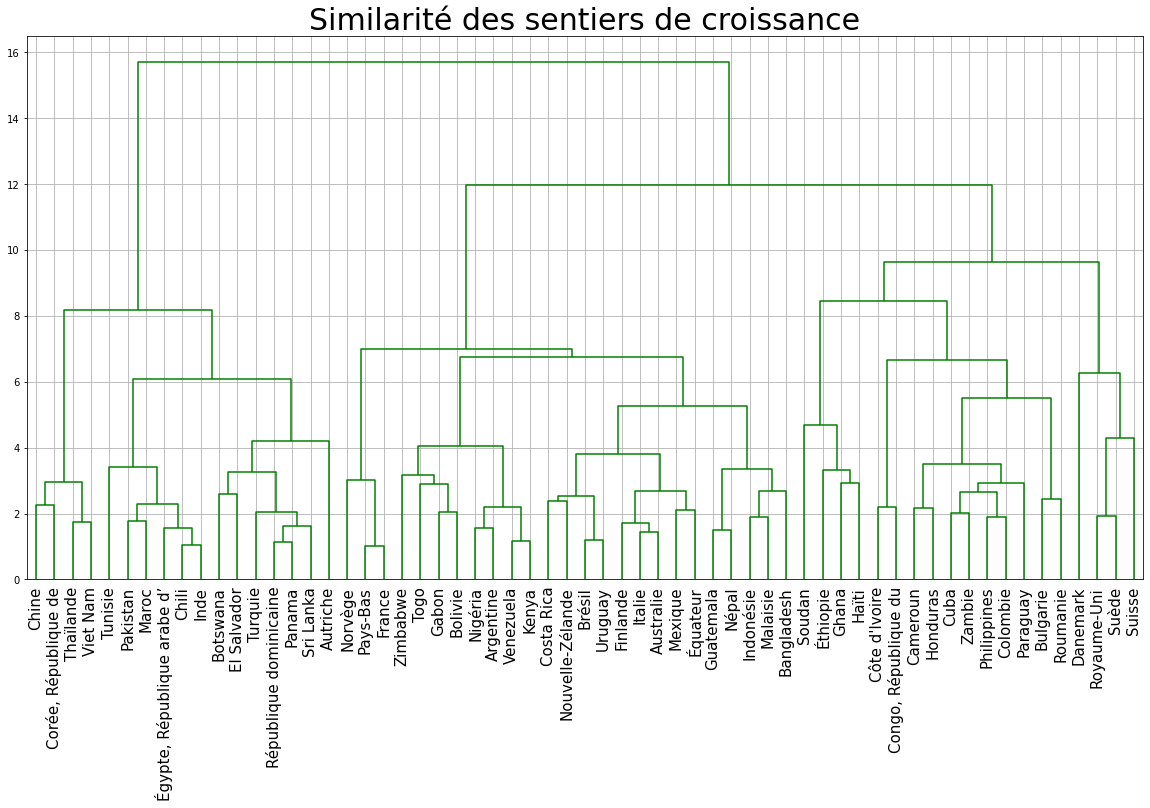

In [49]:
data4_norm = pd.DataFrame()
for i in data_set_4.columns :
    data4_norm[i] = preprocessing.scale(data_set_4[i])
    data4_norm.index = data_set_4.index

hierarc = linkage(data4_norm,method='ward',metric='euclidean',optimal_ordering = True)
fig = plt.subplots(figsize=(20,10))

dendrogram(hierarc,
           #truncate_mode = 'level',
           #p = 4,
           labels=list(dic_code[i] for i in data4_norm.index),
           orientation='top',
           color_threshold=1000,
           leaf_font_size=15) 

plt.title('Similarité des sentiers de croissance', fontsize=30)
plt.grid()
plt.show()

On retrouve des sous groupes de pays proche qu'on retrouvait déjà dans les autres. On peut notamment citer le petit groupe Thailande,Viet-Nam Chine et Corée qui se rapprochent très tot et mettent beaucoup de temps à se raccrocher aux autres clusters, ce qui indique la spécificité de leur sentier de croissance. 


On retrouve aussi deux sentiers a priori plus propre composé du Danemark, la Suisse, le Royaume-Uni et la Suède qui se constitue plus tardivement mais se raccroche aux autres économies dans leur branche plus tardivement.
On a aussi le sentier constitué de la France, la Norvège et les Pays-Bas, qui se regroupe assez tot et rejoint assez tard les clusters adjacents. Cependant on peut noté que ces deux clusters sont assez éloignés, ce qui peut laisser penser qu'il y a deux types 
de sentier plus 'propre'. Cela appuie les résultats que l'on a obtenu plus tôt où l'on pouvait retrouver cette séparation des pays entre les clusters. 


On retrouve aussi un cluster composé du Pakistan, du Maroc, de l'Egypte, de la Tunisie, du Chili et de l'Inde qui forme un cluster de pays en développement. On peut voir que ceux ci se raccrochent ensuite à un Cluster plus gros composés de pays comme la Turquie ou le Bostwana, ce qui nous montre la spécificité de ces économies qui se raccrochent tard à un autre groupe de pays "en développement" tout en se formant relativement tot.

Nous analyserons plus bas plus précisément ces clusters et leur données. 
Pour l'instant nous allons chercher à mieux visualiser le processus d'agrégation des clusters au travers de cartes :

In [169]:
def geo_plot_clas (df,indic,Titre = None,couleur = 'Oranges',legend = False,norm=True, vmin = None,vmax=None) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe (ici on utilise df1 pour avoir l'équivalence entre Country code et Country name)
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df1)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            _
            
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))
    if Titre != None :
        ax.set_title(Titre, fontsize = 20)
    
    gdf = create_gdf(df[['Country Code',indic]],map_monde)
    if norm :
        gdf[indic] = log_norm(gdf[indic])
    if vmax != None :
        Norm = Normalize(vmin = vmin,vmax = vmax)
    if vmax == None :
        Norm = Normalize()

    gplt.choropleth(gdf,
                    hue = indic,
                    cmap = couleur,
                    norm = Norm,
                    legend = legend,
                    ax=ax)
        
    plt.show()

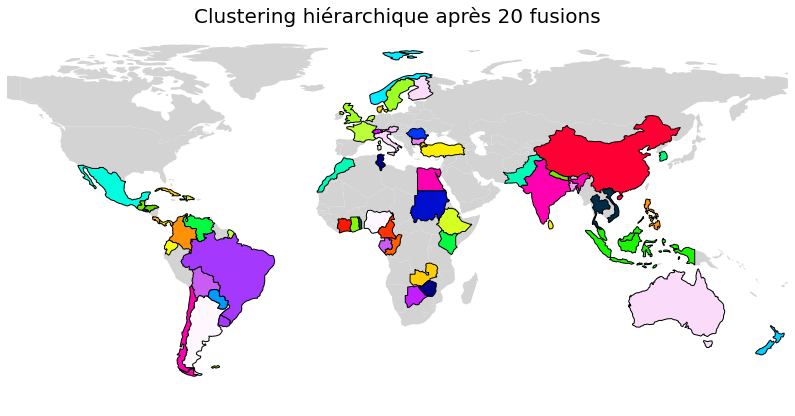

In [51]:
rep_map = data_set_4.copy()
rep_map['Country Code'] = rep_map.index
rep_map['Cluster_hierarc_20'] = cut_tree(hierarc).T[19]
geo_plot_clas(rep_map,
              'Cluster_hierarc_20',
              Titre = 'Clustering hiérarchique après 20 fusions',
              couleur = 'gist_ncar_r',
              legend=False,
              norm=False,
              vmax = 40,
              vmin = 0
             )

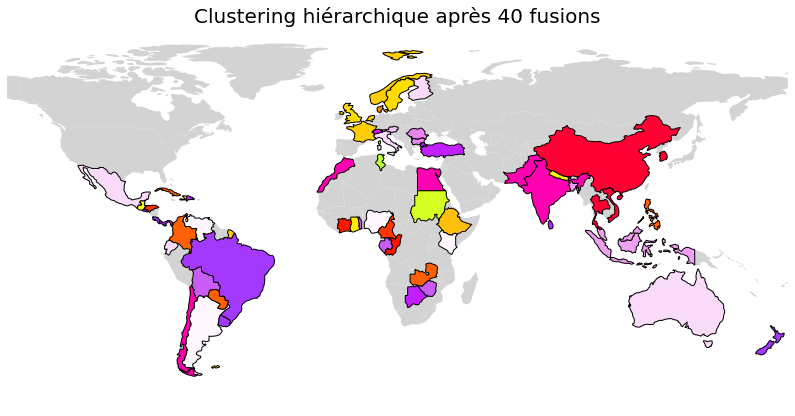

In [52]:
rep_map['Cluster_hierarc_40'] = cut_tree(hierarc).T[39]
geo_plot_clas(rep_map,
              'Cluster_hierarc_40',
              Titre = 'Clustering hiérarchique après 40 fusions',
              couleur = 'gist_ncar_r',
              legend = False,
              norm=False,
              vmax = 40,
              vmin = 0)

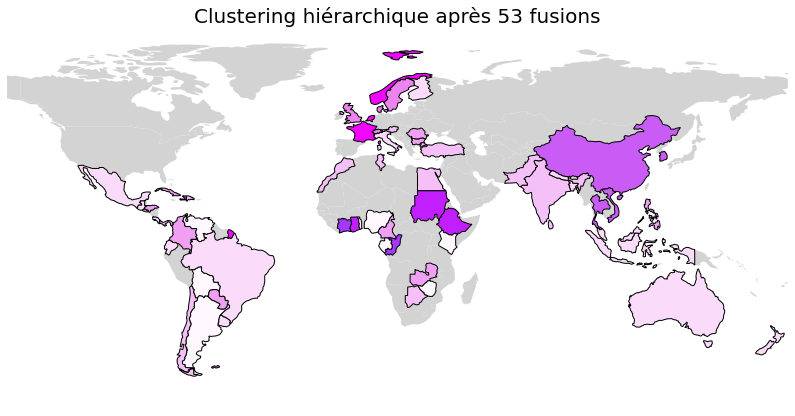

In [53]:
rep_map['Cluster_hierarc_53'] = cut_tree(hierarc).T[52]
geo_plot_clas(rep_map,
              'Cluster_hierarc_53',
              Titre = 'Clustering hiérarchique après 53 fusions',
              couleur = 'gist_ncar_r',
              legend = False,
              norm=False,
              vmax = 40,
              vmin = 0)

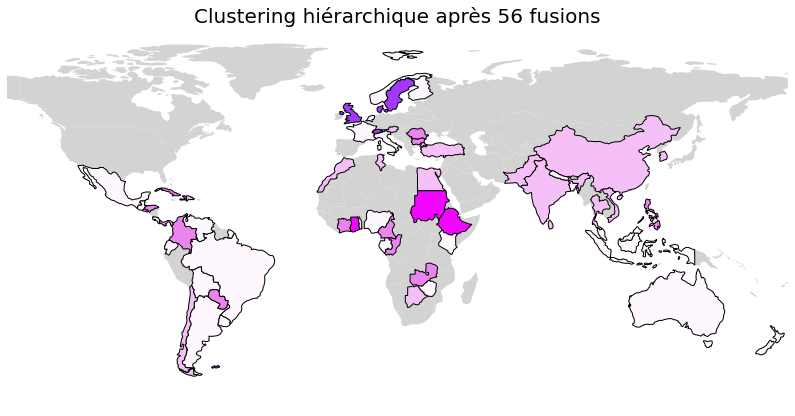

In [54]:
rep_map['Cluster_hierarc_55'] = cut_tree(hierarc).T[56]
geo_plot_clas(rep_map,
              'Cluster_hierarc_55',
              Titre = 'Clustering hiérarchique après 56 fusions',
              couleur = 'gist_ncar_r',
              legend = False,
              norm=False,
              vmax = 20,
              vmin = 0)

### Analyse qualitative des clusters :

On rappelle les statistiques globales des indicateurs afin de faciliter la compréhension des valeurs des clusters.

In [55]:
Des

0  \
Average Growth Rate_GDP (current US$) par Tete           4.037374   
Average Growth Rate_Agriculture, forestry, and ...      -2.251383   
Average Growth Rate_Industry (including constru...      -0.171124   
Average Growth Rate_Émissions totales de GES (k...       0.003190   
Average Growth Rate_Alternative and nuclear ene...       1.526655   
Average Growth Rate_Energy use (kg of oil equiv...       0.984333   
2000_GDP (current US$) par Tete                       7117.808619   
2000_Agriculture, forestry, and fishing, value ...      12.742339   
2000_Industry (including construction), value a...      29.277680   
2000_Émissions totales de GES (kt d’équivalent ...       0.008188   
2000_Alternative and nuclear energy (% of total...       7.621772   
2000_Energy use (kg of oil equivalent per capita)     1599.184106   
Coefficient de _GDP (current US$) par Tete sur ... -680064.717060   
R2 de _GDP (current US$) par Tete sur _Émission...       0.381926   
Coefficient de _GDP (current US$) par Tete sur ...       7.650008   
R2 de _GDP (current US$) par Tete sur _Energy u...       0.565502   

                                                             Var  
Average Growth Rate_GDP (current US$) par Tete      3.157090e+00  
Average Growth Rate_Agriculture, forestry, and ...  2.057566e+00  
Average Growth Rate_Industry (including constru...  1.213523e+00  
Average Growth Rate_Émissions totales de GES (k...  3.380726e+00  
Average Growth Rate_Alternative and nuclear ene...  1.531604e+01  
Average Growth Rate_Energy use (kg of oil equiv...  1.751662e+00  
2000_GDP (current US$) par Tete                     1.089544e+08  
2000_Agriculture, forestry, and fishing, value ...  1.142384e+02  
2000_Industry (including construction), value a...  1.034751e+02  
2000_Émissions totales de GES (kt d’équivalent ...  7.950140e-05  
2000_Alternative and nuclear energy (% of total...  1.141020e+02  
2000_Energy use (kg of oil equivalent per capita)   2.705345e+06  
Coefficient de _GDP (current US$) par Tete sur ...  3.390123e+13  
R2 de _GDP (current US$) par Tete sur _Émission...  1.035006e-01  
Coefficient de _GDP (current US$) par Tete sur ...  1.368770e+02  
R2 de _GDP (current US$) par Tete sur _Energy u...  8.369571e-02

In [56]:
Cluster1 = data4_norm.loc[['THA','VNM','CHN','KOR']]
Cluster1.loc['Moyenne'] = list(Cluster1[i].mean() for i in Cluster1.columns)
print(Cluster1.loc['Moyenne'])

Average Growth Rate_GDP (current US$) par Tete                                                             2.308099
Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)                            -1.009847
Average Growth Rate_Industry (including construction), value added (% of GDP)                              0.308393
Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete                                1.634787
Average Growth Rate_Alternative and nuclear energy (% of total energy use)                                 0.883503
Average Growth Rate_Energy use (kg of oil equivalent per capita)                                           2.269545
Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete    0.329925
R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete             1.446761
Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil eq

On peut voir que ce cluster possède en moyenne un bon taux de croissance, un recul du secteur agricole, et un fort taux d'augmentation des émissions de gazs à effet de serre et du secteur énergétique. 
Celui-ci représente donc un cluster d'économie émergente très polluante qui base leur stratégie de développement sur la consommation d'énergie et l'émission de gaz à effet de serre (ou du moins le développement de secteur fortement émetteurs). 

C'est un  cluster que l'on a déjà régulièrement identifié dans les précédents clustering, et ce même entre les différentes bases. C'est donc peu étonnant que le clustering hiérarchique les rapproche.


In [57]:
Cluster2 = data4_norm.loc[['PAK','MAR','EGY','IND','TUN']]
Cluster2.loc['Moyenne'] = list(Cluster2[i].mean() for i in Cluster2.columns)
print(Cluster2.loc['Moyenne'])

Average Growth Rate_GDP (current US$) par Tete                                                            -0.099312
Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)                             0.892545
Average Growth Rate_Industry (including construction), value added (% of GDP)                             -0.100103
Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete                                0.800672
Average Growth Rate_Alternative and nuclear energy (% of total energy use)                                -0.177938
Average Growth Rate_Energy use (kg of oil equivalent per capita)                                           0.793453
Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete    0.406161
R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete             1.476579
Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil eq

Ce cluster se différencie très clairement du précédent de part son taux de croissance moyen, et la quasi-stagnation de la part de l'agriculture dans le PIB. Celui-ci enregistre de plus une croissance des émissions plus faibles et moins de développement des énergies alternatives. De plus, ce deuxième cluster se caractérise aussi par un développement moins important de l'industrie que le premier cluster sur la période. 

On peut donc voir que ces deux clusters caractérisent deux types de pays en développement : certains qui ont su s'industrialiser et développer leur industrie pour faire croitre leur revenu par habitant (Korée, Chine ...)au prix d'une croissance forte de leur émission de gaz à effet de serre. 
A l'inverse, les autres n'ont pas pu se développer avec la même ampleur et ont conservé une forte part d'agriculture dans leur PIB. On  peut remarquer que le second cluster réunit différents pays avec une forte croissance démographique qui a probablement annnulé la croissance du PIB par tête. 

In [58]:
Cluster3 = data4_norm.loc[['CHE','GBR','SWE','DNK']]
Cluster3.loc['Moyenne'] = list(Cluster3[i].mean() for i in Cluster3.columns)
print(Cluster3.loc['Moyenne'])

Average Growth Rate_GDP (current US$) par Tete                                                            -0.234809
Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)                            -0.661736
Average Growth Rate_Industry (including construction), value added (% of GDP)                             -0.590470
Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete                               -0.761604
Average Growth Rate_Alternative and nuclear energy (% of total energy use)                                 1.149809
Average Growth Rate_Energy use (kg of oil equivalent per capita)                                          -1.035736
Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete   -2.268715
R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete             0.972101
Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil eq

On voit dans ce cluster des économies propre, ou du moins en voies de décarbonation comme peut le montrer le fait que la part des énergies vertes ou nucléaires de développent plus que la moyennne. Aussi cela est montré par la baisse des émissions de gaz à effet de serre (en effet on a une déviation par rapport à la moyenne de -0,76, sachant que la valeur moyenne est de de 0.003 et que la variance est de 3.33, on retrouve une déviation moyenne de -2,51 % à l'année, ce qui est non négligeable). De plus, ceux ci voient un recul du secteur industriel et agricole dans leur économie plus que la moyenne au profit du secteur tertiaire. 

In [59]:
Cluster4 = data4_norm.loc[['FRA','NOR','NLD']]
Cluster4.loc['Moyenne'] = list(Cluster4[i].mean() for i in Cluster4.columns)
print(Cluster4.loc['Moyenne'])

Average Growth Rate_GDP (current US$) par Tete                                                            -0.258338
Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)                             0.281012
Average Growth Rate_Industry (including construction), value added (% of GDP)                             -0.734985
Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete                               -0.590644
Average Growth Rate_Alternative and nuclear energy (% of total energy use)                                 0.098563
Average Growth Rate_Energy use (kg of oil equivalent per capita)                                          -0.557918
Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete   -1.890344
R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete             0.569892
Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil eq

On peut voir ici que on a un cluster relativement similaire, mais avec un développement des énergies propres moins important et une baisse plus lente du secteur de l'agriculture. De plus on a aussi une baisse plus lentes des émissions de gazs à effet de serre. 
Aussi, on peut observer une augmentation 2 fois plus fortes en moyennes de la consommation d'énergie sur la période. 

Ainsi, on peut voir que ces deux clusters se différencient quir regroupent des pays développés se différecient majoritairement par deux choses : l'agriculture et le développement des énergies renouvelables et nucléaires moins important. 
On peut donc comprendre pourquoi l'algorithme a plutot rapproché le deuxième cluster de pays développé avec des économies plus pauvres et plus orientés sur le secteur agricoles.

On a ici analysé 4 clusters qui ressortaient du lot de part leur isolement du reste des pays. On peut en déduire que ces pays ont suivi des sentiers de croissances paticuliers. 
On peut souligner que le reste des clusters des pays fusionnent relativement bas en terme d'inertie, et qu'il est difficile de reconnaitre des motifs autres que ceux-ci au sein du graphe.
Cependant l'analuse de ce graphe nous permet tout de même donc de distinguer deux chemins de croissances opposés : les chemins très pollueurs mais avec une forte augmentation du PIB et des chemins moins carbonés et plutot en voie de transition énergétique, mais avec une plus faible augmentation du PIB. 


## Conclusion

Après avoir analysé nos données, nous avons pu distinguer différentes trajectoires typiques de l'économie au cours de cette période. Les pays ayant eu une croissance économique forte sont ceux qui ont fortement augmenté leur consommation d'énergie, et c'est souvent passé par une forte augmentation des émissions de gaz à effet de serre. On retrouve sans surprise des pays comme la Chine ou la Corée dans ce groupe. Cette trajectoire semble être celle qu'un autre groupe de pays a suivi, bien que de manière moins marquée. On retrouve dans ce second groupe des pays comme la Turquie et le Chili, avec des tendances semblables mais moins prononcées. 

A l'opposé, on retrouve des pays comme la Suisse ou les pays scandinaves, à la croissance plus lente quoique dans la moyenne. Ces pays ont la particularité d'avoir un rythme d'augmentation de la consommation d'énergie par habitant plus faible, voire négatif pour certains. Ils ont aussi développé des énergies propres, notamment des énergies renouvelables sur la période. Ce groupe de pays apparait de manière plus marqué encore lorsqu'on prend en compte leur niveau de développement en 2000, en plus de leur trajectoire. Dans ce cadre, on retrouve que les économies développées sont très similaires, et s'opposent fortement aux pays en développement. 

L'analyse des trajectoires seules nous a permis de se débarrasser de ce biais, et d'obtenir un rapprochement assez peu intuitif entre certains pays développés et des pays peu développés. Par exemple, certains pays comme l'Autriche ou l'Italie se retrouvent souvent rapprochés de pays moins développés comme le Pakistan. Si l'on étudie en effet uniquement les tendances des évolutions des paramètres que nous avons retenus, il s'agit de pays similaires. La croissance est relativement faible, comme l'augmentation de l'utilisation d'énergie et des émissions de gaz à effet de serre. Ces composantes sont assez liées, et la part des énergies propres y est très faible et peu développée. Il s'agit en fait de pays peu dynamiques, qui soit sont déjà développés sans être compétitif, soit n'arrivent pas vraiment à se développer économiquement.

On peut regretter que le faible nombre de pays sur lesquels nous avons tous nos indicateurs rend nos résultats assez peu robustes. Nous n'avons notamment pas réussi à identifier de tendance permettant de vraiment distinguer entre les pays les moins avancés. Ces derniers étaient souvent regroupés ensemble, mais dans un cluster peu robuste. Il est possible qu'avec des données plus exhaustives, on aurait pu distinguer plus finement entre ces trajectoires. Mais nous n'avons réussi à obtenir de résultats robustes que sur des trajectoires très atypiques, qui ne concernent pas la majorité des pays. 

La conclusion que nous pouvons faire de cette analyse est qu'il n'y a pas eu de croissance dynamique sans forte augmentation de la consommation d'énergie par habitant, cette dernière s'accompagnant de fortes émissions de gaz à effet de serre. Cependant, les pays développés ont tendance à davantage développer des énergies plus propres (ce qui inclue par construction l'énergie nucléaire), et à limiter voire réduire leur empreinte carbone. Cela est souvent concomitant à un ralentissement du dynamisme économique. Mais s'il n'est pas possible de se prononcer sur la possibilité d'une croissance perpétuelle verte, on peut dire que bien que le développement des pays semble passer par de la pollution, ce modèle pollueur semble s'amenuiser chez les pays développés. Ainsi, il semble possible que toutes les économies effectuent une transition verte, a minima lorsqu'elles atteignent un niveau de développement économique important. De plus, il parait probable que le développement des énergies propres soit plus aisé aujourd'hui qu'au début des années 1980, du fait des innovations scientifiques. Il s'agit là d'un phénomène que nous ne pouvions par construction pas détecter, mais qui peut nous permettre d'être optimiste à propos du développement des pays émergeants, et de sa soutenabilité.

# Annexe : préparation de l'oral :

In [204]:
# Fonctions pour récupérer les figures :
#Pour des DataFrame avec des données temporelles :
def geo_plot_sav (df,indic,annee,Titre = None,couleur = 'Oranges',norm=True, vmax= None, vmin = None) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe: 
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            _
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))
    if Titre != None :
        ax.set_title(Titre, fontsize = 20)

    gdf = create_gdf(df.loc[rech_ligne_indic(indic,df),['Country Code',annee]],map_monde)
    
    if norm :
        gdf[annee] = log_norm(gdf[annee])
    
    if vmax!= None :
        Norm = Normalize(vmin = vmin,vmax = vmax)
    if vmax == None :
        Norm = Normalize()
   
    gplt.choropleth(gdf,
                    hue = annee,
                    cmap = couleur,
                    legend=True,
                    norm = Norm,
                    ax=ax)
    #plt.show()
    #nom_fichier = 'Carte de '+ indic[0:3]
    #if re.search(indic,".{,4}"+'Croissance'+".*?") is not None :
    #    nom_fichier = nom_fichier + ' Croissance'
    #if re.search(indic,".*?"+'par Tete'+".*?") is not None :  
    #    nom_fichier = nom_fichier + ' par Tete'
    #if re.search(indic,".*?"+'pourcent'+".*?") is not None :  
    #    nom_fichier = nom_fichier + ' en pourcent'
    #plt.savefig(nom_fichier+' '+annee+'.png')
    plt.savefig(Titre+'.png', dpi = 2000)
    
    
#Pour des DataFrame sans données temporelles :

def geo_plot_clas_sav (df,indic,Titre = None,couleur = 'Oranges',legend = False,norm=True, vmin = None,vmax=None) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe (ici on utilise df1 pour avoir l'équivalence entre Country code et Country name)
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df1)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            _
            
    #On peut dés maintenant commencer le plot :
    
    gdf = create_gdf(df[['Country Code',indic]],map_monde)
    
    if norm :
        gdf[indic] = log_norm(gdf[indic])
    if vmax != None :
        Norm = Normalize(vmin = vmin,vmax = vmax)
    if vmax == None :
        Norm = Normalize()
    #nom_fichier = 'Carte de '+ indic[0:3]
    #if re.search(indic,".{,4}"+'Croissance'+".*?") is not None :
    #    nom_fichier = nom_fichier + ' Croissance'
    #if re.search(indic,".*?"+'par Tete'+".*?") is not None :  
    #    nom_fichier = nom_fichier + ' par Tete'
    #if re.search(indic,".*?"+'pourcent'+".*?") is not None :  
    #    nom_fichier = nom_fichier + ' en pourcent'
    
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))
    if Titre != None :
        ax.set_title(Titre, fontsize = 20)
    
    gplt.choropleth(gdf,
                    hue = indic,
                    cmap = couleur,
                    legend = legend,
                    norm = Norm,
                    ax=ax)
    #plt.savefig(nom_fichier+'.png', dpi = 2000)
    plt.savefig(Titre+'.png', dpi = 2000)

def triplot_seaborn_sav (var1,var2,country_code,Titre,var3 = None, color = 'rocket_r') :
    year = list(df1)[3:]
    for i in range(len(year)):
        year[i] = float(year[i])

    df_plot = df1.drop(['Country Name', 'Country Code', 'Indicator Name'], axis = 1)
    df_plot.loc['year'] = year
    df_plot = df_plot.T
    if var3 != None :
        graph = sns.relplot(data = df_plot,
                            x= 'year', y = country_code + var1,
                            hue = country_code + var3, 
                            size = country_code + var2, 
                            palette = color, 
                            sizes = (30,300), 
                            kind = 'scatter')
    else :
        graph = sns.relplot(data = df_plot,
                            x= 'year', y = country_code + var1,
                            size = country_code + var2, 
                            sizes = (30,300),
                            kind = 'scatter')
    
    graph.set_axis_labels('Date',str(var1)[1:])
    plt.title(Titre)
    #nom_fichier = 'Graph de '
    #for indic in [var1,var2] :
    #    nom_fichier = nom_fichier +' '+ indic[1:4]
    #    if re.search(indic,".{,4}"+'Croissance'+".*?") is not None :
    #        nom_fichier = nom_fichier + ' Croissance'
    #    if re.search(indic,".*?"+'par Tete'+".*?") is not None :  
    #        nom_fichier = nom_fichier + ' par Tete'
    #    if re.search(indic,".*?"+'pourcent'+".*?") is not None :  
    #        nom_fichier = nom_fichier + ' en pourcent'
    #plt.savefig(nom_fichier+' '+'.png')
    plt.savefig(Titre+'.png', dpi = 2000)
    
    return(graph)

    
df_plot

Average Growth Rate_GDP (current US$) par Tete  \
ABW                                        4.957681   
AFG                                             NaN   
AGO                                        3.737056   
ALB                                        6.258686   
AND                                        3.111329   
..                                              ...   
WSM                                        4.767743   
YEM                                             NaN   
ZAF                                        1.877096   
ZMB                                        1.758102   
ZWE                                        1.250988   

     Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)  \
ABW                                                NaN                                
AFG                                                NaN                                
AGO                                                NaN                                
ALB                                                NaN                                
AND                                                NaN                                
..                                                 ...                                
WSM                                                NaN                                
YEM                                                NaN                                
ZAF                                          -2.856965                                
ZMB                                          -4.090009                                
ZWE                                          -1.557183                                

     Average Growth Rate_Industry (including construction), value added (% of GDP)  \
ABW                                                NaN                               
AFG                                                NaN                               
AGO                                                NaN                               
ALB                                                NaN                               
AND                                                NaN                               
..                                                 ...                               
WSM                                                NaN                               
YEM                                                NaN                               
ZAF                                          -1.412356                               
ZMB                                           0.190953                               
ZWE                                          -0.877013                               

     Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
ABW                                                NaN                             
AFG                                          -2.165492                             
AGO                                          -3.812102                             
ALB                                          -1.034237                             
AND                                                NaN                             
..                                                 ...                             
WSM                                           1.364511                             
YEM                                           1.674159                             
ZAF                                                NaN                             
ZMB                                          -1.123488                             
ZWE                                           1.833836                             

     Average Growth Rate_Alternative and nuclear energy (% of total energy use)  \
ABW                                                NaN                            
AFG                                                NaN                            
AGO     

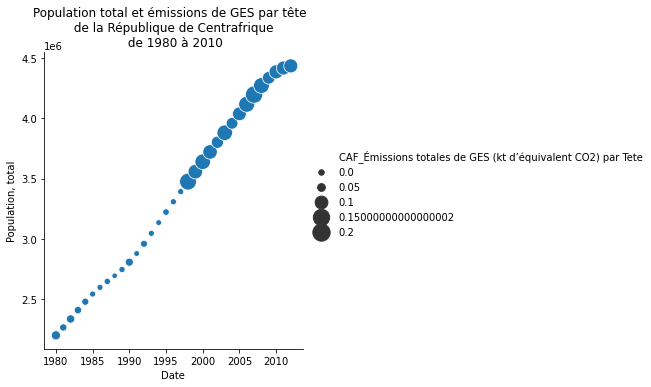

In [202]:
triplot_seaborn_sav('_Population, total',
                    '_Émissions totales de GES (kt d’équivalent CO2) par Tete',
                    'CAF',
                    'Population total et émissions de GES par tête  \n de la République de Centrafrique \n de 1980 à 2010',
                    var3 = None,
                    color = 'rocket_r') 

In [214]:
df_plot = data.copy()
df_plot['Country Code'] = df_plot.index
df_plot

Average Growth Rate_GDP (current US$) par Tete  \
ABW                                        4.957681   
AFG                                             NaN   
AGO                                        3.737056   
ALB                                        6.258686   
AND                                        3.111329   
..                                              ...   
WSM                                        4.767743   
YEM                                             NaN   
ZAF                                        1.877096   
ZMB                                        1.758102   
ZWE                                        1.250988   

     Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)  \
ABW                                                NaN                                
AFG                                                NaN                                
AGO                                                NaN                                
ALB                                                NaN                                
AND                                                NaN                                
..                                                 ...                                
WSM                                                NaN                                
YEM                                                NaN                                
ZAF                                          -2.856965                                
ZMB                                          -4.090009                                
ZWE                                          -1.557183                                

     Average Growth Rate_Industry (including construction), value added (% of GDP)  \
ABW                                                NaN                               
AFG                                                NaN                               
AGO                                                NaN                               
ALB                                                NaN                               
AND                                                NaN                               
..                                                 ...                               
WSM                                                NaN                               
YEM                                                NaN                               
ZAF                                          -1.412356                               
ZMB                                           0.190953                               
ZWE                                          -0.877013                               

     Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete  \
ABW                                                NaN                             
AFG                                          -2.165492                             
AGO                                          -3.812102                             
ALB                                          -1.034237                             
AND                                                NaN                             
..                                                 ...                             
WSM                                           1.364511                             
YEM                                           1.674159                             
ZAF                                                NaN                             
ZMB                                          -1.123488                             
ZWE                                           1.833836                             

     Average Growth Rate_Alternative and nuclear energy (% of total energy use)  \
ABW                                                NaN                            
AFG                                                NaN                            
AGO     

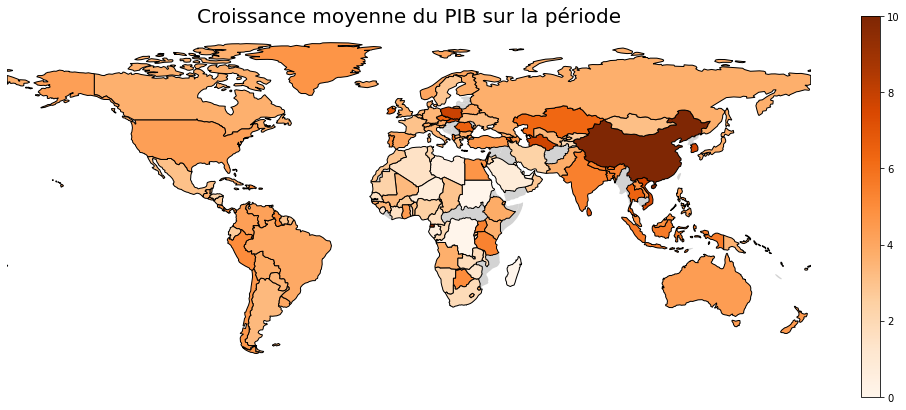

In [193]:
geo_plot_clas_sav(df_plot,
                  'Average Growth Rate_GDP (current US$) par Tete',
                  Titre = 'Croissance moyenne du PIB sur la période',
                  couleur = 'Oranges',
                  legend = True,
                  norm=False,
                  vmin =0,
                  vmax=10)

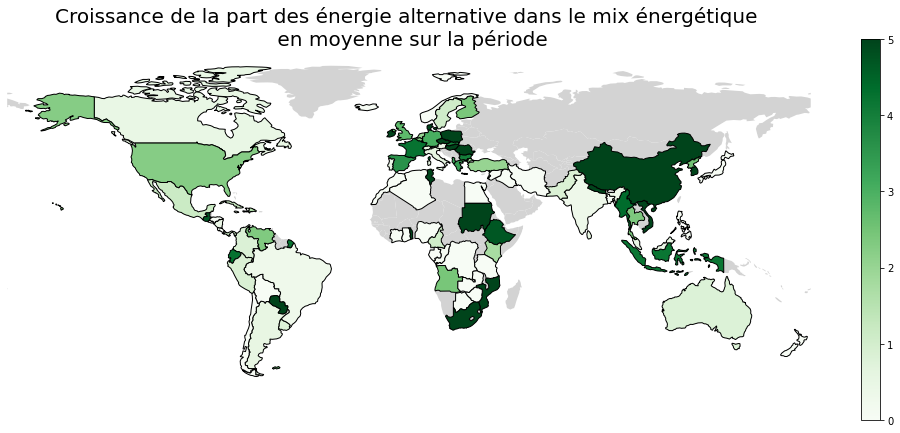

In [218]:
geo_plot_clas(df_plot,
                  'Average Growth Rate_Alternative and nuclear energy (% of total energy use)',
                  Titre = 'Croissance de la part des énergie alternative dans le mix énergétique \n en moyenne sur la période',
                  couleur = 'Greens',
                  legend = True,
                  norm=False,
                  vmin =0,
                  vmax=5)

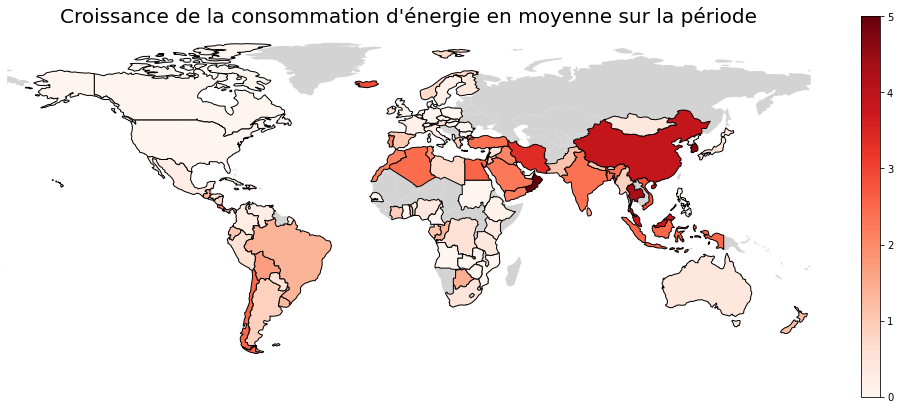

In [225]:
geo_plot_clas(df_plot,
                  'Average Growth Rate_Energy use (kg of oil equivalent per capita)',
                  Titre = 'Croissance de la consommation d\'énergie en moyenne sur la période',
                  couleur = 'Reds',
                  legend = True,
                  norm=False,
                  vmin =0,
                  vmax=5)